This notebook contains all basic unsupervised analysis of the data, preparing data objects that are used by other notebooks that perform specialised analyses.

# Load Packages and Set Global Variables

All variable definitions necessary to customize notebook execution are included in this section.

<a id="imports"></a>

## Imports and Settings

In [1]:
import anndata
import cellrank as cr
import diffxpy.api as de
import numpy as np
import scanpy as sc
import scvelo as scv
import sys
import pandas as pd
import pickle
import seaborn as sb
import tftools
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
from matplotlib_venn import venn3


print(sc.__version__)
print(anndata.__version__)

np.random.seed(seed=1)

1.8.1
0.7.6


Set up paths to all data resources used throughout notebook here:

In [2]:
sc.settings.verbosity = 3 # amount of output

root_dir = '.'

dir_in = root_dir + 'data/'
base_dir = root_dir + 'results/'
dir_gene_sets = root_dir + 'data/gene_sets/MSigDBlists/'
dir_cc_gene_set = root_dir + 'data/gene_sets/regev_lab_cell_cycle_genes_10X.txt'

# Make sure that these folders exist:
dir_out = base_dir + 'figures/multiome/'
dir_tables = base_dir + 'tables/multiome/'
dir_anndata = base_dir + f'anndata/multiome/'
dir_de = base_dir + 'de/multiome/'

dir_tables_new_tf = base_dir + 'tables/afmos/'
dir_anndata_new_tf = base_dir + 'anndata/afmos/'

fn_cutnrun2_diff = dict([
    (x, dir_in + "cutnrun/" + x + "_peaks.broadPeak")
    for x in [
        "Ascl1_MyoD1_R1", "mAscl1_MyoD1_R1", "MyoD1_R1",
        "Ascl1_MyoD1_R2", "mAscl1_MyoD1_R2", "MyoD1_R2"
    ]
])
fn_cutnrun2_diff_norm = dir_in + "cutnrun/picard_deduplication.tsv"
fn_cutnrun2_consensus_counts = dir_in + "cutnrun/broadPeak/consensus/pseudoAB/pseudoAB.consensus_peaks.featureCounts.txt"


fns_atac_bed = [dir_in + x for x in [
    "atac/atac_peak_annotation.tsv",
]]

fn_myod1_chip = dir_in +"reference_data/GSE126410_TGM_flagMyoD_MDallinput.idrpeaks.0.1.merged.bed"
fn_gtf = dir_in +"reference_data/Mus_musculus.GRCm38.100.chr.gtf"
fn_encode_annot = dir_in + "reference_data/ENCFF904ZZH.bed"

sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, scanpy=True)
sc.settings.figdir = dir_out
scv.settings.figdir = dir_out
print(sys.version)

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.6
scanpy      1.8.1
sinfo       0.3.4
-----
2f7ece400a652629565c523b34ee61b04afa385c    NA
PIL                                         8.3.2
absl                                        NA
anyio                                       NA
appnope                                     0.1.2
astunparse                                  1.6.3
attr                                        21.2.0
babel                                       2.9.1
backcall                                    0.2.0
batchgl

In [3]:
constructs = [
    "synAscl1",
    "synMyod1",
    "synmutantAscl1",
]
constructs_color_dict = {
    "DsRed": ['DsRed-plus-gn', 'DsRed-minus-gn'],
    "AcGFP1": ['AcGFP1-plus-gn', 'AcGFP1-minus-gn'],
    "EBFP2": ['EBFP2-plus-gn', 'EBFP2-minus-gn']
}
constructs_color = [
    "DsRed",
    "AcGFP1",
    "EBFP2"
]
endogenous_genes = [
    "Ascl1",
    "Myod1",
]

<a id="Global"></a>

## Global Variables

Set whether anndata objects are recomputed or loaded from cache.

In [4]:
bool_recomp = True

Set whether clustering is recomputed or loaded from saved .obs file. Loading makes sense if the clustering changes due to a change in scanpy or one of its dependencies and the number of clusters or the cluster labels change accordingly.

In [5]:
bool_recluster = False

Set whether cluster cache is overwritten. Note that the cache exists for reproducibility of clustering, see above.

In [6]:
bool_write_cluster_cache = False

Set whether to produce plots, set to False for test runs.

In [7]:
bool_plot = True

Set colors for UMAP:

In [8]:
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

# Utils

# Loading Data

## RNA

In [9]:
adata_rna_proc2 = anndata.read_h5ad(dir_anndata + "adata_soupx_proc.h5ad")
adata_rna_proc2.obs["inferred_category_real"] = pd.Categorical([
    x.split(") ")[-1].split("AcGFP1, ")[-1].split("DsRed, ")[-1].split("EBFP2, ")[-1]
    for x in adata_rna_proc2.obs["inferred_category_real"].values
], categories=['empty', 'no transgene', 'synAscl1', 'synmutantAscl1', 'synMyod1', 'synAscl1, synMyod1', 'synmutantAscl1, synMyod1'])
adata_rna_proc2.obs["inferred_category_real"] = [
    "".join(",".join(x.split(", ")).split("syn"))
    if x not in ["empty", "no transgene"] else "untransfected"
    for x in adata_rna_proc2.obs["inferred_category_real"].values
]

## ATAC

In [10]:
adata_atac_proc2 = anndata.read_h5ad(dir_anndata + "adata_atac_proc.h5ad")
adata_atac_proc2.obs["inferred_category_real"] = pd.Categorical([
    x.split(") ")[-1].split("AcGFP1, ")[-1].split("DsRed, ")[-1].split("EBFP2, ")[-1]
    for x in adata_atac_proc2.obs["inferred_category_real"].values
], categories=['empty', 'no transgene', 'synAscl1', 'synmutantAscl1', 'synMyod1', 'synAscl1, synMyod1', 'synmutantAscl1, synMyod1'])
adata_atac_proc2.obs["inferred_category_real"] = [
    "".join(",".join(x.split(", ")).split("syn"))
    if x not in ["empty", "no transgene"] else "untransfected"
    for x in adata_atac_proc2.obs["inferred_category_real"].values
]

In [11]:
peaks_atac = dict([(f"sample_{i}", tftools.reading.Loader10xAtacBed(v))
                   for i, v in enumerate(fns_atac_bed)])

## Cut'N'Run

In [12]:
peaks_diff2 = dict([(k, tftools.reading.LoaderChipseqBed(v)) 
                    for k, v in fn_cutnrun2_diff.items()])

In [13]:
peaks_consensus2 = pd.read_csv(fn_cutnrun2_consensus_counts, sep="\t", skiprows=1)
peaks_consensus2.columns = [x.split(".mLb.clN.bam")[0] 
                           for x in peaks_consensus2.columns]
peaks_consensus2

,Geneid,Chr,Start,End,Strand,Length,mAscl1_MyoD1_R2,Ascl1_MyoD1_R1,MyoD1_R2,Ascl1_MyoD1_R2,MyoD1_R1,mAscl1_MyoD1_R1
0,Interval_1,1,4910957,4911142,+,186,3,0,6,0,0,2
1,Interval_2,1,5020996,5021255,+,260,0,0,7,3,0,5
2,Interval_3,1,6287584,6288098,+,515,5,4,14,9,5,7
3,Interval_4,1,7397679,7397992,+,314,2,2,3,5,9,7
4,Interval_5,1,9773338,9773561,+,224,0,0,5,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...
11025,Interval_11026,X,166503442,166503723,+,282,6,0,7,1,7,1
11026,Interval_11027,X,166803166,166803573,+,408,17,14,32,9,21,18
11027,Interval_11028,X,166805392,166805839,+,448,32,16,49,17,28,21
11028,Interval_11029,X,169882408,169882749,+,342,9,3,22,6,9,6


In [14]:
norm_factors2 = pd.read_csv(fn_cutnrun2_diff_norm, sep="\t")
norm_factors2 = dict(list(zip(
    [x.split("_T1")[0] for x in norm_factors2["Category"].values],
    norm_factors2["Unique Pairs"].values
)))
print(norm_factors2)
norm_factors2_scaled = dict([
    (k, v / norm_factors2["Input_" + k.split("_")[-1]]) 
    for k, v in norm_factors2.items()
])
print(norm_factors2_scaled)

{'Ascl1_MyoD1_R1': 110686, 'Ascl1_MyoD1_R2': 155914, 'Input_R1': 65730, 'Input_R2': 77154, 'MyoD1_R1': 128744, 'MyoD1_R2': 87834, 'mAscl1_MyoD1_R1': 234046, 'mAscl1_MyoD1_R2': 150484}
{'Ascl1_MyoD1_R1': 1.6839494903392667, 'Ascl1_MyoD1_R2': 2.020815511833476, 'Input_R1': 1.0, 'Input_R2': 1.0, 'MyoD1_R1': 1.9586794462193824, 'MyoD1_R2': 1.1384244498016953, 'mAscl1_MyoD1_R1': 3.560718089152594, 'mAscl1_MyoD1_R2': 1.9504367887601421}


In [15]:
for r in ["R1", "R2"]:
    for i, x in enumerate(["MyoD1", "Ascl1_MyoD1", "mAscl1_MyoD1"]):
        peaks_consensus2[x + f"_{r}_norm"] = peaks_consensus2[f"{x}_{r}"].values / norm_factors2_scaled[f"{x}_{r}"]

# CutNRun-only analysis

## Set comparisons

In [16]:
for k, v in peaks_diff2.items():
    print(f"diff {k}: {v.tab.shape[0]} peaks")

diff Ascl1_MyoD1_R1: 901 peaks
diff mAscl1_MyoD1_R1: 1123 peaks
diff MyoD1_R1: 5521 peaks
diff Ascl1_MyoD1_R2: 1275 peaks
diff mAscl1_MyoD1_R2: 1880 peaks
diff MyoD1_R2: 9059 peaks


### Individual peaks

Overlap matrix on individually called peaks:

overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5', 'chr3', 'chr10', 'chr11', 'chr2', 'chr4', 'chr19', 'chr8', 'chr1', 'chr6', 'chr18', 'chrx', 'chr16'}
non-overlapping chromsomes: set()
overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5', 'chr3', 'chr10', 'chr11', 'chr2', 'chr4', 'chr19', 'chr8', 'chr1', 'chr6', 'chr18', 'chrx', 'chr16'}
non-overlapping chromsomes: set()
overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5', 'chr3', 'chr10', 'chr11', 'chr2', 'chr4', 'chr19', 'chr8', 'chr1', 'chr6', 'chr18', 'chrx', 'chr16'}
non-overlapping chromsomes: {'chrmt'}
overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5', 'chr3', 'chr10', 'chr11', 'chr2', 'chr4', 'chr19', 'chr8', 'chr1', 'chr6', 'chr18', 'chrx', 'chr16'}
non-overlapping chromsomes: set()
overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'c

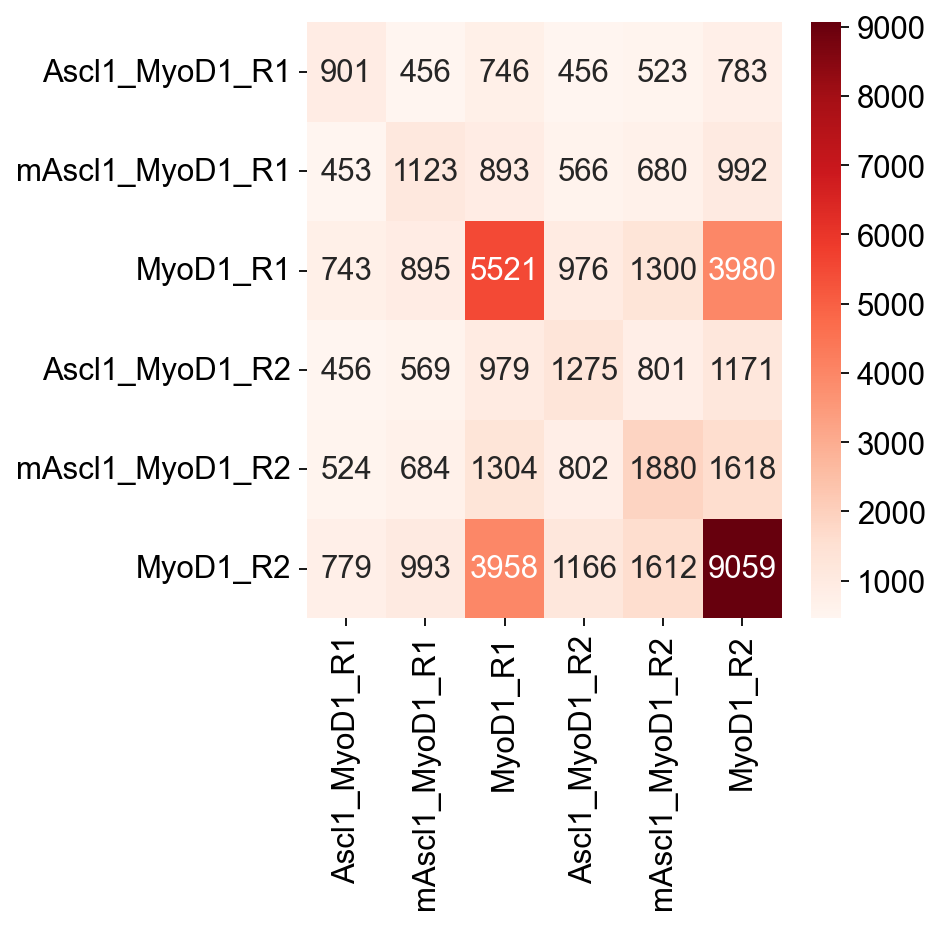

,Ascl1_MyoD1_R1,mAscl1_MyoD1_R1,MyoD1_R1,Ascl1_MyoD1_R2,mAscl1_MyoD1_R2,MyoD1_R2
Ascl1_MyoD1_R1,901,456,746,456,523,783
mAscl1_MyoD1_R1,453,1123,893,566,680,992
MyoD1_R1,743,895,5521,976,1300,3980
Ascl1_MyoD1_R2,456,569,979,1275,801,1171
mAscl1_MyoD1_R2,524,684,1304,802,1880,1618
MyoD1_R2,779,993,3958,1166,1612,9059


In [17]:
mat_overlaps = pd.DataFrame(np.zeros((6, 6), dtype="int"), index=list(peaks_diff2.keys()), 
                            columns=list(peaks_diff2.keys()))
for k1, v1 in peaks_diff2.items():
    for k2, v2 in peaks_diff2.items():
        key_bed = v1
        tftools.overlaps.OverlapBedBed(bed_key=key_bed, bed_query=v2).query(cumulative=True)
        mat_overlaps.loc[k1, k2] = int(np.sum(key_bed.tab["matches"].values > 0))
fig, ax = plt.subplots(1,1, figsize=(6,6))
sb.heatmap(mat_overlaps, cmap="Reds", annot=True, fmt=".0f", ax=ax)
plt.tight_layout()
plt.show()
mat_overlaps

overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5', 'chr3', 'chr10', 'chr11', 'chr2', 'chr4', 'chr19', 'chr8', 'chr1', 'chr6', 'chr18', 'chrx', 'chr16'}
non-overlapping chromsomes: set()
overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5', 'chr3', 'chr10', 'chr11', 'chr2', 'chr4', 'chr19', 'chr8', 'chr1', 'chr6', 'chr18', 'chrx', 'chr16'}
non-overlapping chromsomes: set()
overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5', 'chr3', 'chr10', 'chr11', 'chr2', 'chr4', 'chr19', 'chr8', 'chr1', 'chr6', 'chr18', 'chrx', 'chr16'}
non-overlapping chromsomes: {'chrmt'}
overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5', 'chr3', 'chr10', 'chr11', 'chr2', 'chr4', 'chr19', 'chr8', 'chr1', 'chr6', 'chr18', 'chrx', 'chr16'}
non-overlapping chromsomes: set()
overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'c

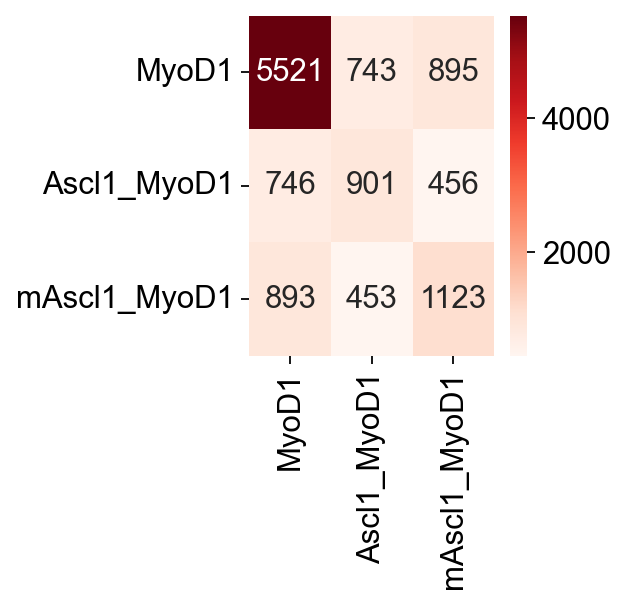

              MyoD1  Ascl1_MyoD1  mAscl1_MyoD1
MyoD1          5521          743           895
Ascl1_MyoD1     746          901           456
mAscl1_MyoD1    893          453          1123
overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5', 'chr3', 'chr10', 'chr11', 'chr2', 'chr4', 'chr19', 'chr8', 'chr1', 'chr6', 'chr18', 'chrx', 'chr16'}
non-overlapping chromsomes: set()
overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5', 'chr3', 'chr10', 'chr11', 'chr2', 'chr4', 'chr19', 'chr8', 'chr1', 'chr6', 'chr18', 'chrx', 'chr16'}
non-overlapping chromsomes: set()
overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5', 'chr3', 'chr10', 'chr11', 'chr2', 'chr4', 'chr19', 'chr8', 'chr1', 'chr6', 'chr18', 'chrx', 'chr16'}
non-overlapping chromsomes: {'chrmt'}
overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5', 'chr3', 'chr10', 'chr11', '

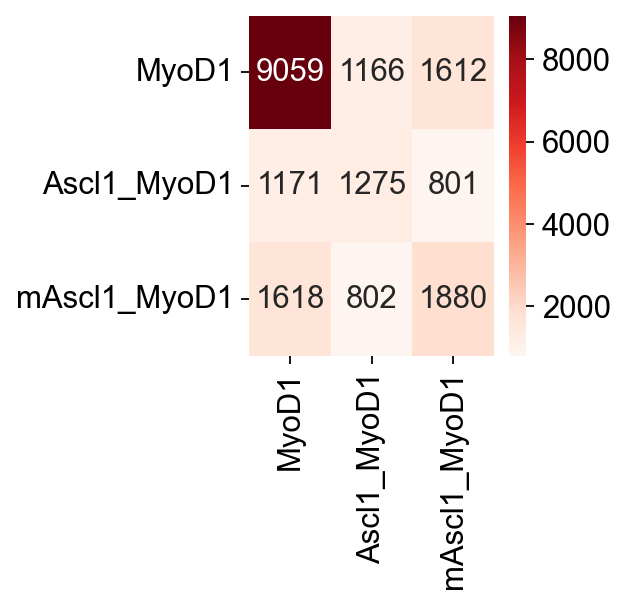

              MyoD1  Ascl1_MyoD1  mAscl1_MyoD1
MyoD1          9059         1166          1612
Ascl1_MyoD1    1171         1275           801
mAscl1_MyoD1   1618          802          1880


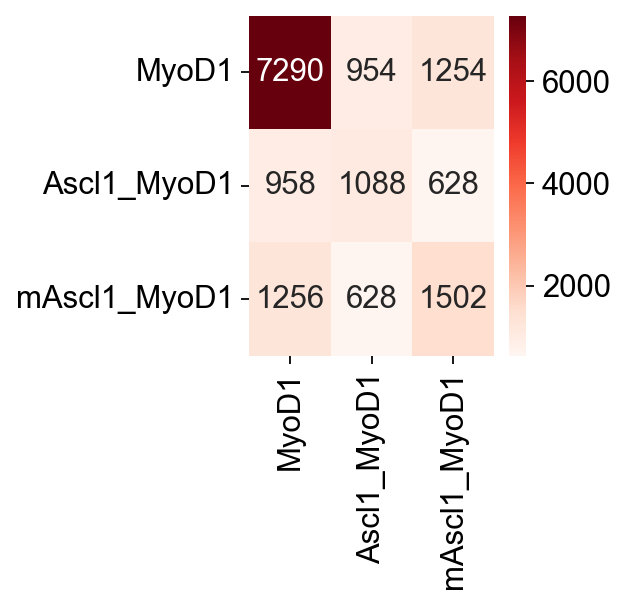

In [18]:
conds = ["MyoD1", "Ascl1_MyoD1", "mAscl1_MyoD1"]
mat_overlaps = {}
for r in ["R1", "R2"]:
    mat_overlaps[r] = pd.DataFrame(np.zeros((3, 3), dtype="int"), index=conds, columns=conds)
    for k1, v1 in [(k1, v1) for k1, v1 in peaks_diff2.items() if k1.endswith(r)]:
        for k2, v2 in [(k2, v2) for k2, v2 in peaks_diff2.items() if k2.endswith(r)]:
            key_bed = v1
            tftools.overlaps.OverlapBedBed(bed_key=key_bed, bed_query=v2).query(cumulative=True)
            mat_overlaps[r].loc[k1.split("_R")[0], k2.split("_R")[0]] = \
                int(np.sum(key_bed.tab["matches"].values > 0))
    fig, ax = plt.subplots(1,1, figsize=(4, 4))
    sb.heatmap(mat_overlaps[r], cmap="Reds", annot=True, fmt=".0f", ax=ax)
    plt.tight_layout()
    plt.savefig(dir_out + f"EV5d_{r}.pdf")
    plt.show()
    print(mat_overlaps[r])

mat_overlaps_ave = np.asarray(mat_overlaps["R1"] + mat_overlaps["R2"], dtype="float32") / 2
mat_overlaps_ave = pd.DataFrame(mat_overlaps_ave, index=conds, columns=conds)
fig, ax = plt.subplots(1,1, figsize=(4, 4))
sb.heatmap(mat_overlaps_ave, cmap="Reds", annot=True, fmt=".0f", ax=ax)
plt.tight_layout()
plt.savefig(dir_out + f"6g.pdf")
plt.show()

## Quantitative comparisons

### Consensus peaks

Overlap matrix on consensus peaks:

In [19]:
for r in ["R1", "R2"]:
    for i, x in enumerate(["MyoD1", "Ascl1_MyoD1", "mAscl1_MyoD1"]):
        print(f"total counts {x}_{r}: {np.sum(peaks_consensus2[f'{x}_{r}'].values)}")
        print(f"total counts after normalisation {x}_{r}: {np.sum(peaks_consensus2[f'{x}_{r}_norm'].values)}")
        print(f"non-zero peaks {x}_{r}: {np.sum(peaks_consensus2[f'{x}_{r}'].values > 0)}")

total counts MyoD1_R1: 146588
total counts after normalisation MyoD1_R1: 74840.21966072204
non-zero peaks MyoD1_R1: 10648
total counts Ascl1_MyoD1_R1: 67214
total counts after normalisation Ascl1_MyoD1_R1: 39914.49885261009
non-zero peaks Ascl1_MyoD1_R1: 9534
total counts mAscl1_MyoD1_R1: 132193
total counts after normalisation mAscl1_MyoD1_R1: 37125.37659263564
non-zero peaks mAscl1_MyoD1_R1: 10630
total counts MyoD1_R2: 198315
total counts after normalisation MyoD1_R2: 174201.28321606666
non-zero peaks MyoD1_R2: 10906
total counts Ascl1_MyoD1_R2: 84930
total counts after normalisation Ascl1_MyoD1_R2: 42027.5871313673
non-zero peaks Ascl1_MyoD1_R2: 10204
total counts mAscl1_MyoD1_R2: 100248
total counts after normalisation mAscl1_MyoD1_R2: 51397.71797666197
non-zero peaks mAscl1_MyoD1_R2: 10330


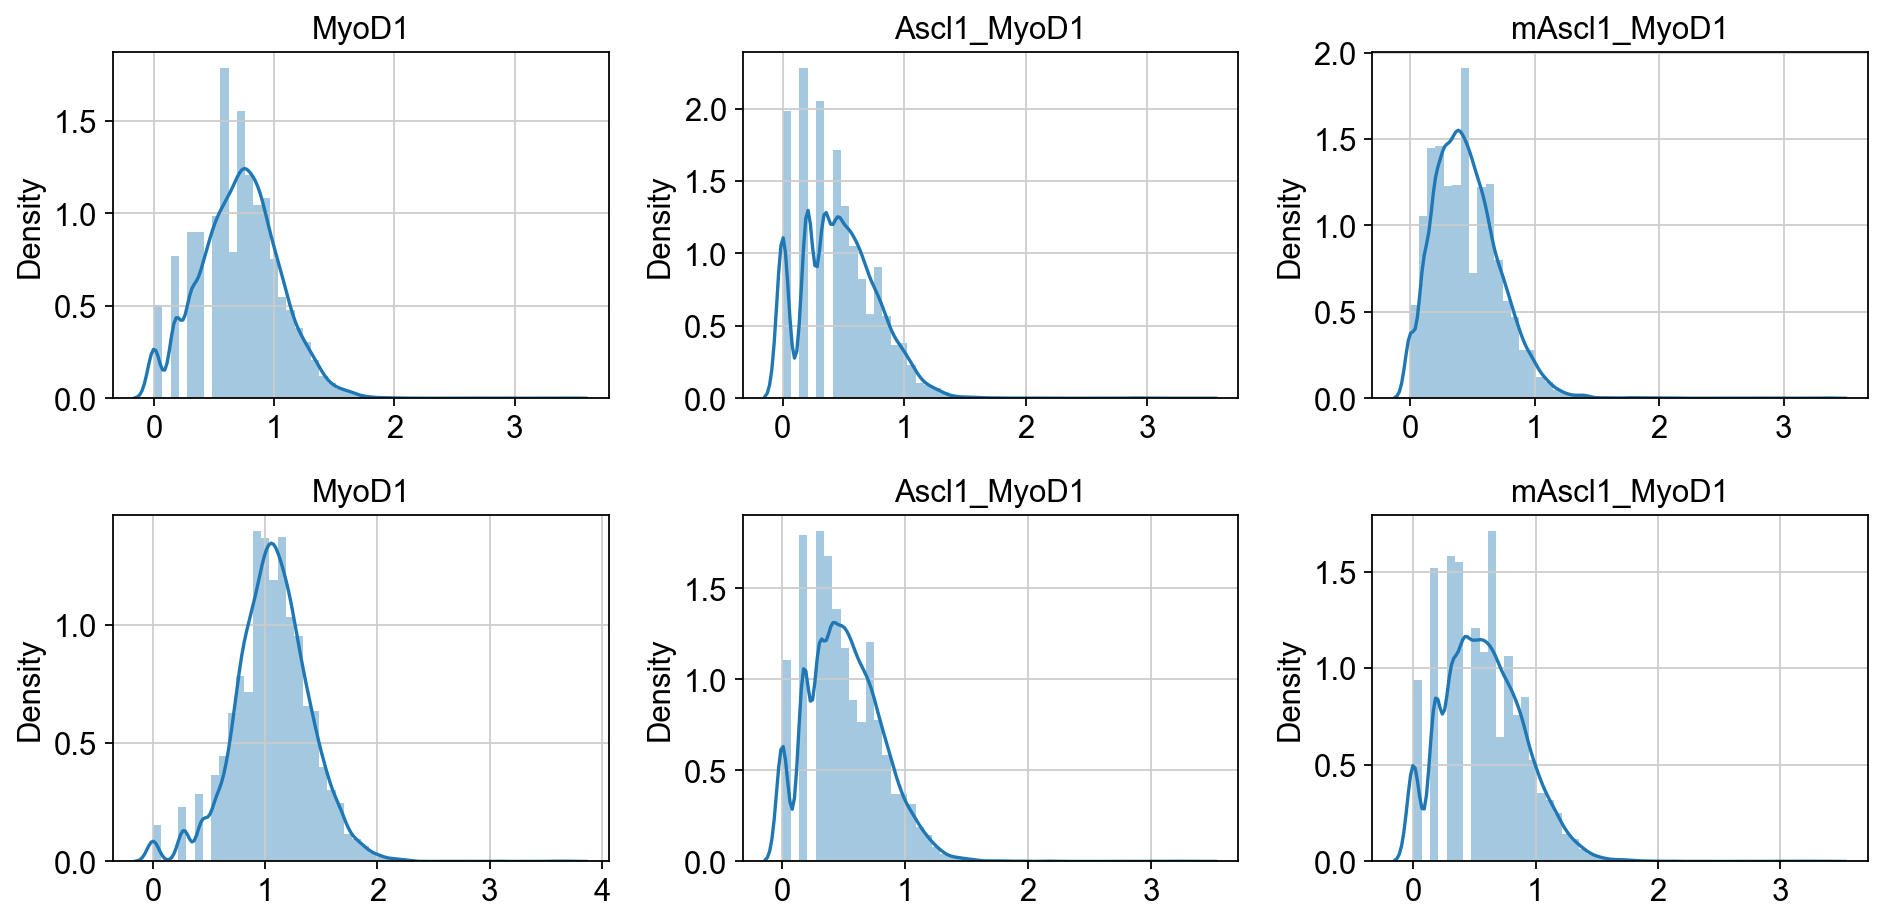

In [20]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6))
for j, r in enumerate(["R1", "R2"]):
    for i, x in enumerate(["MyoD1", "Ascl1_MyoD1", "mAscl1_MyoD1"]):
        sb.distplot(np.log(peaks_consensus2[f"{x}_{r}_norm"].values + 1) / np.log(10), ax=ax[j, i])
        ax[j, i].set_title(x)
plt.tight_layout()
plt.show()

/Users/davfischer/opt/miniconda3/envs/collideseq/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/Users/davfischer/opt/miniconda3/envs/collideseq/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/Users/davfischer/opt/miniconda3/envs/collideseq/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


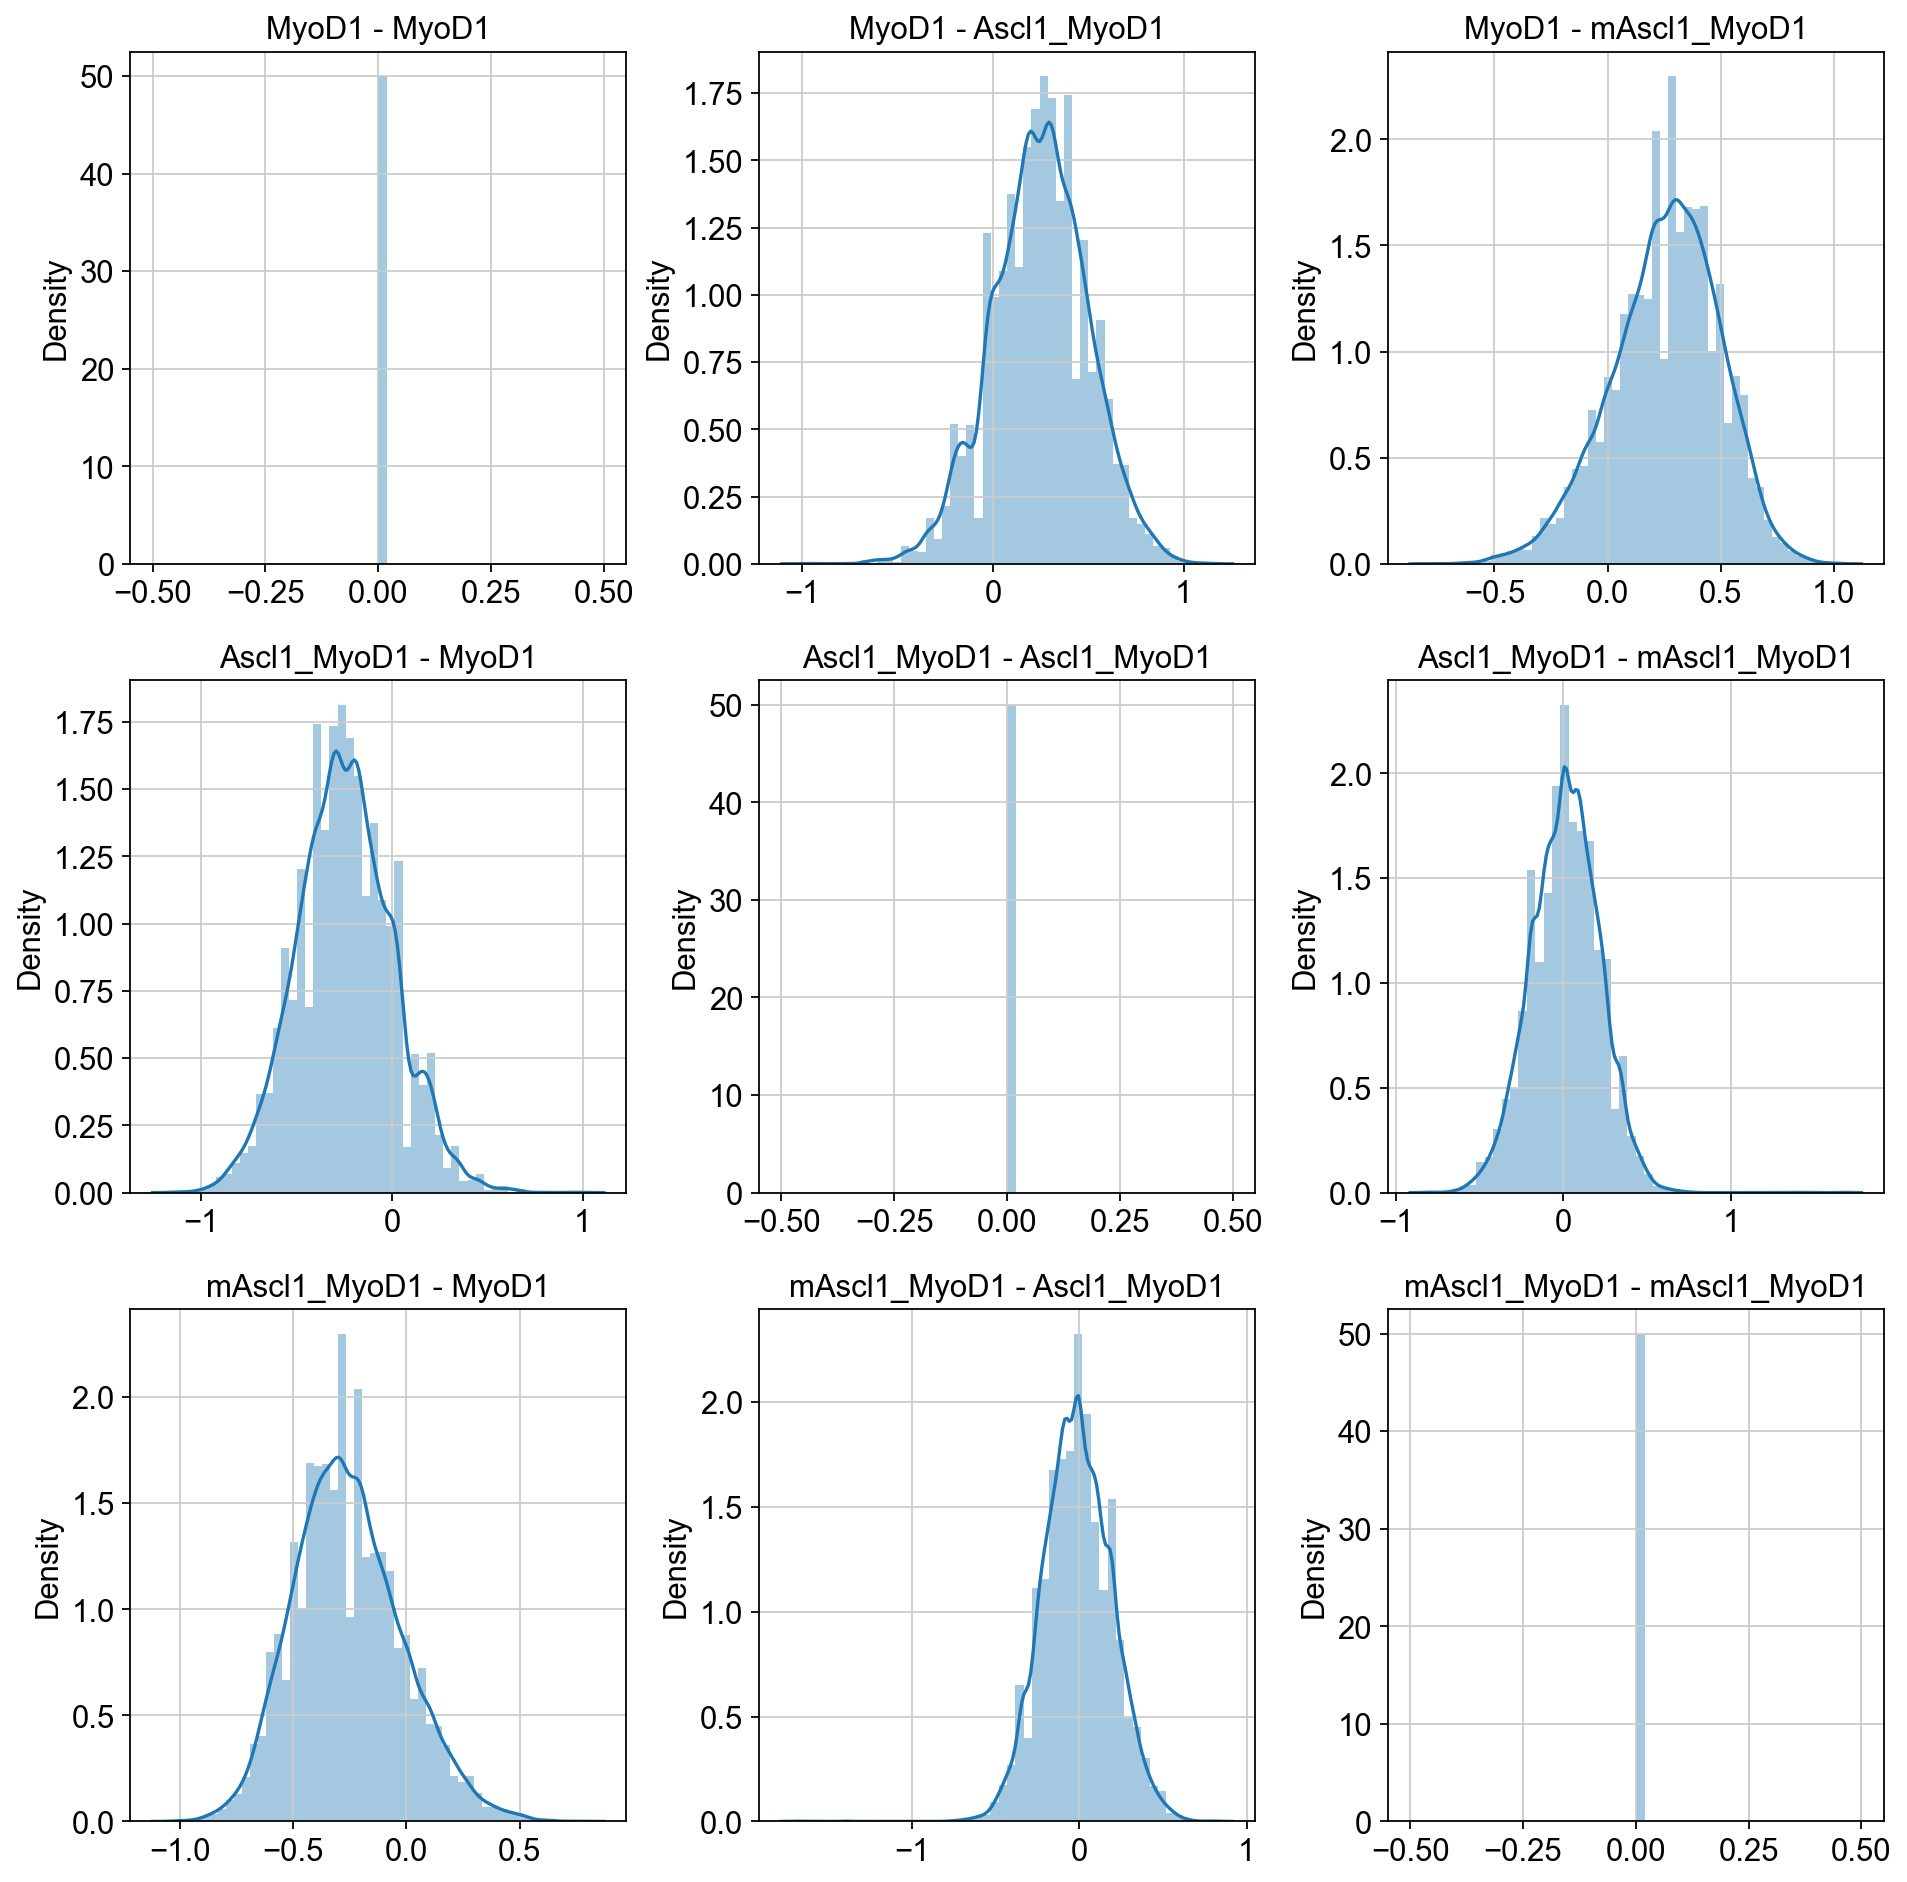

/Users/davfischer/opt/miniconda3/envs/collideseq/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/Users/davfischer/opt/miniconda3/envs/collideseq/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/Users/davfischer/opt/miniconda3/envs/collideseq/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


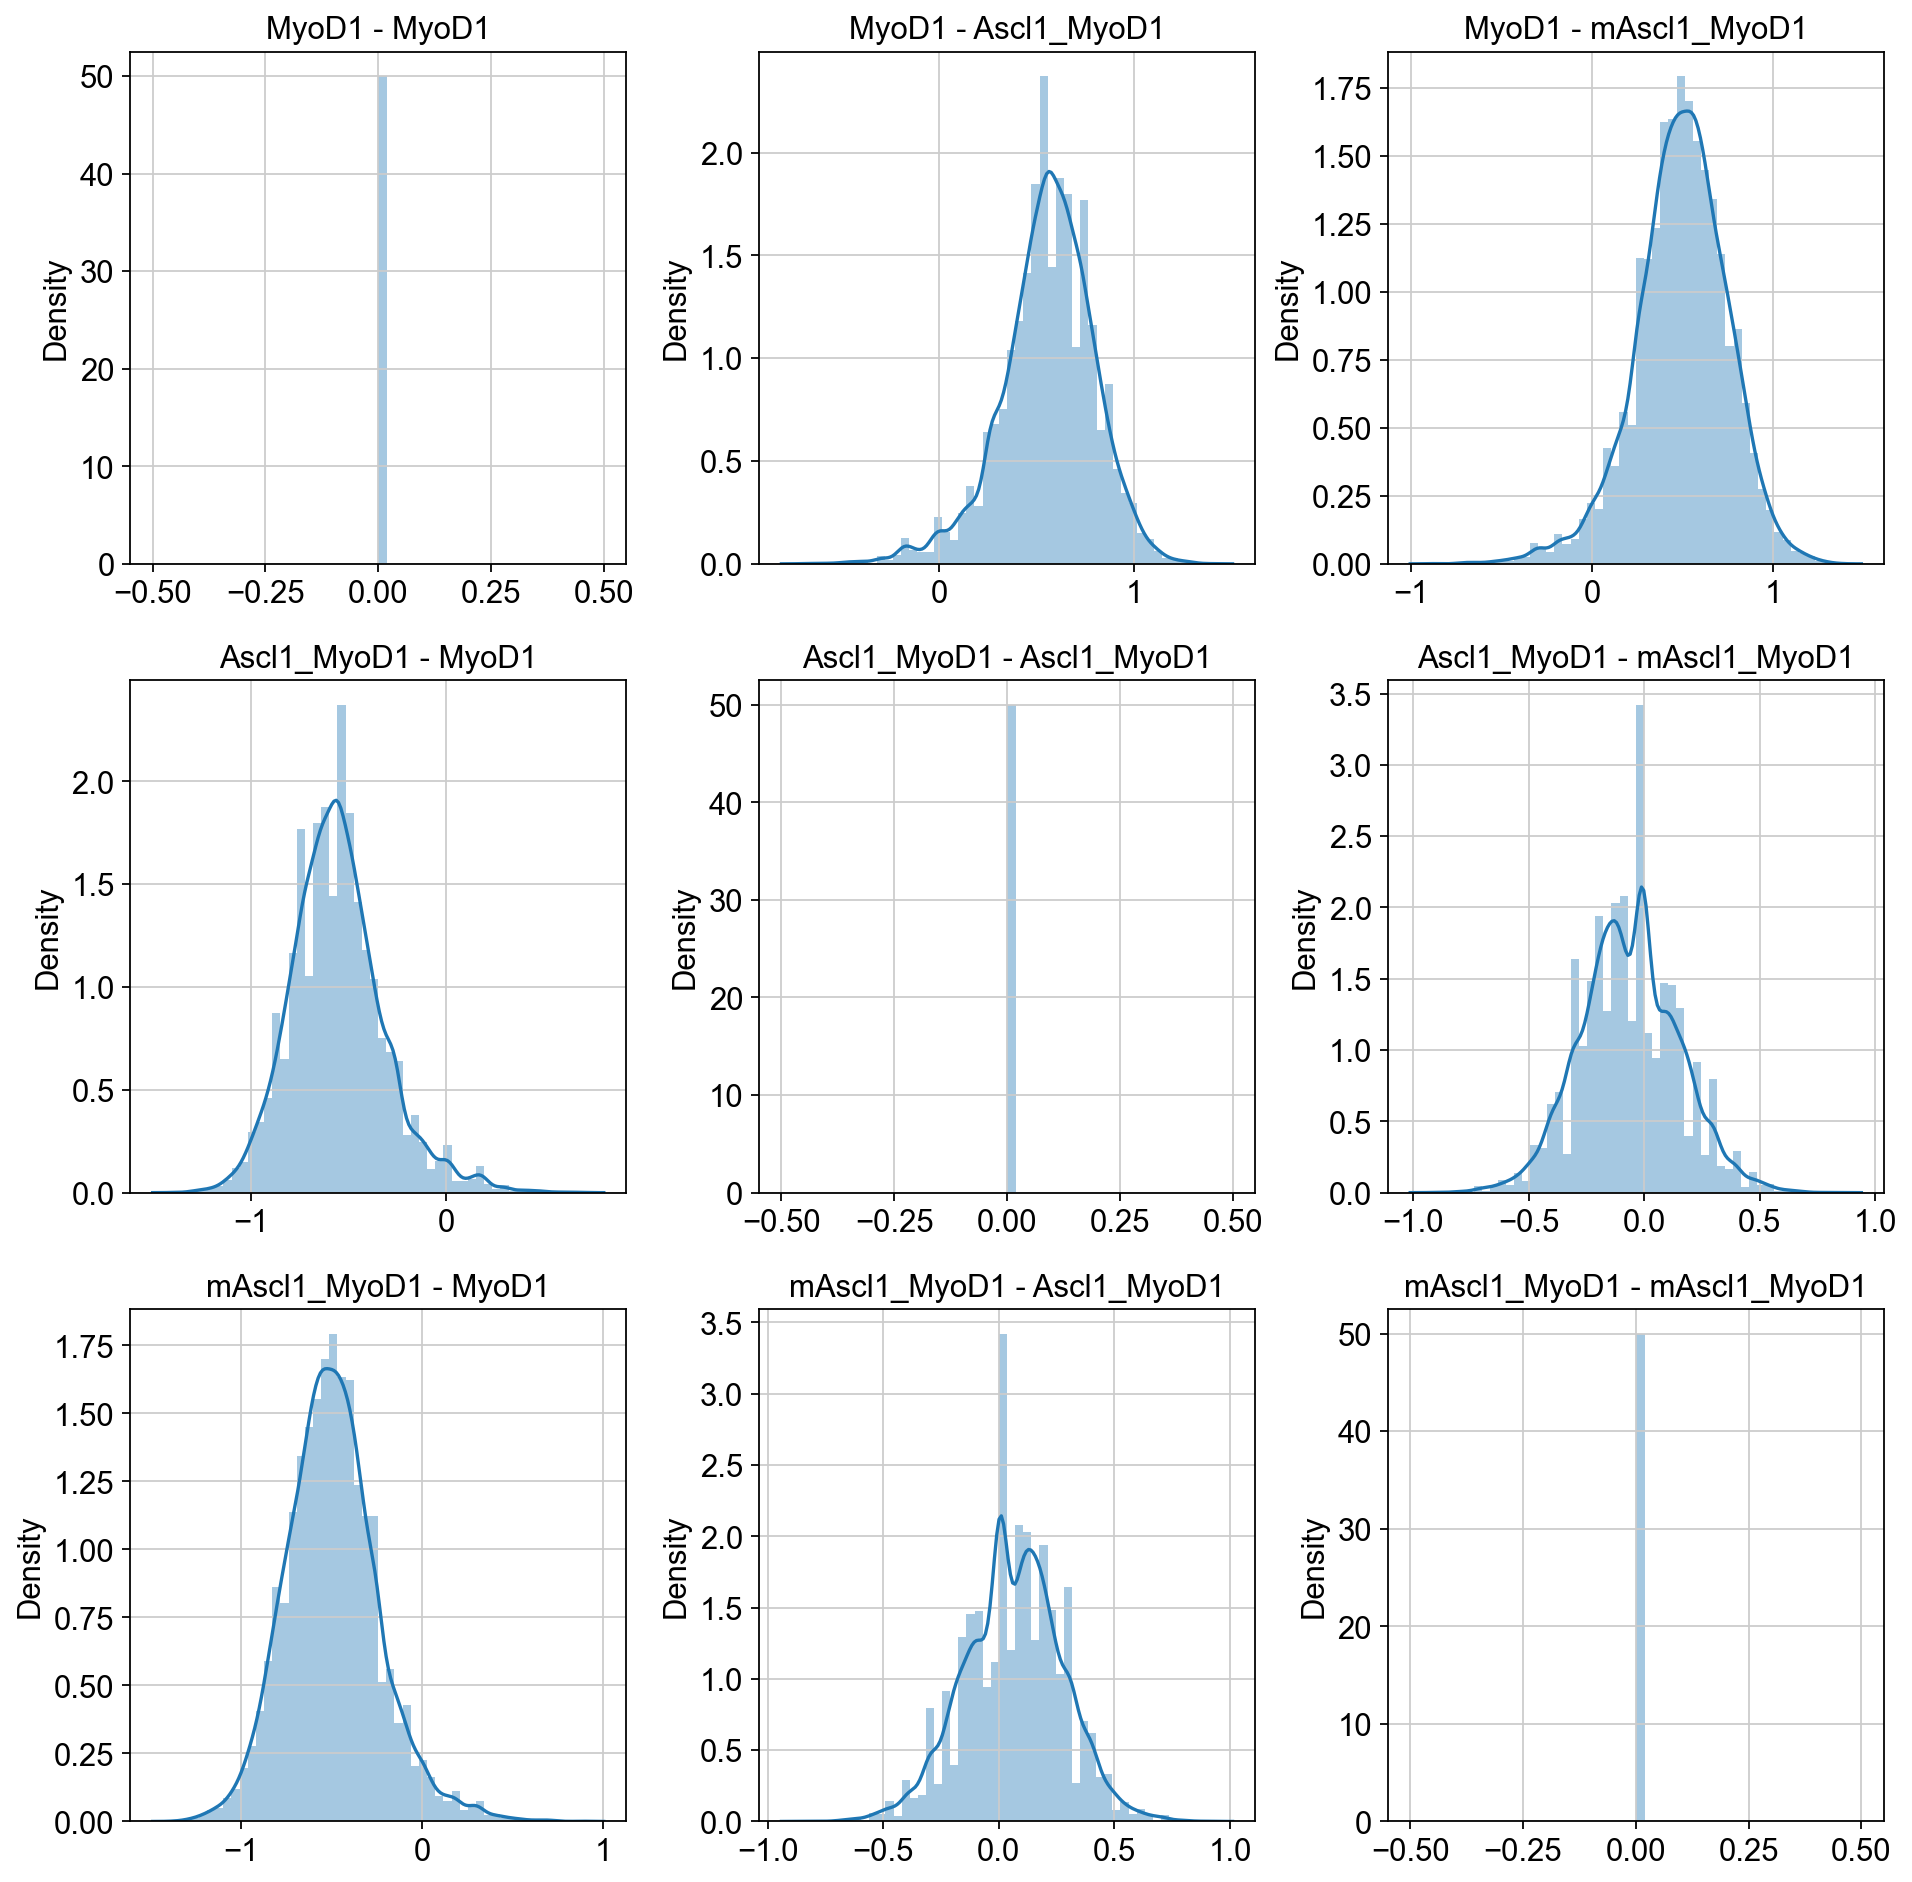

In [21]:
for j, r in enumerate(["R1", "R2"]):
    fig, ax = plt.subplots(3, 3, figsize=(12, 12))
    for i, x in enumerate(["MyoD1", "Ascl1_MyoD1", "mAscl1_MyoD1"]):
        for j, y in enumerate(["MyoD1", "Ascl1_MyoD1", "mAscl1_MyoD1"]):
            diff = np.log(peaks_consensus2[x + "_" + r + "_norm"].values + 1) / np.log(10) - \
                np.log(peaks_consensus2[y + "_" + r + "_norm"].values + 1) / np.log(10)
            sb.distplot(diff, ax=ax[i, j])
            ax[i, j].set_title(f"{x} - {y}")
    plt.tight_layout()
    plt.show()

## Overlap to genome annotation

In [22]:
v1 = tftools.reading.BaseBed6File(fn=fn_encode_annot)
v1.tab["class"] = pd.read_csv(
    filepath_or_buffer=fn_encode_annot,
    sep="\t",
    skiprows=0,
    index_col=None,
    usecols=[9],
    header=None,
).values[:,0]

dict_classes = {}
for k2, v2 in peaks_diff2.items():
    tftools.overlaps.OverlapBedBed(bed_key=v1, bed_query=v2).query(cumulative=True)
    tab_subset = v1.tab.loc[v1.tab.matches > 0, :].copy()
    dict_classes[k2] = dict(tab_subset.groupby("class").size())

overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5', 'chr3', 'chr10', 'chr11', 'chr2', 'chr4', 'chr19', 'chr8', 'chr1', 'chr6', 'chr18', 'chrx', 'chr16'}
non-overlapping chromsomes: {'chry'}
overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5', 'chr3', 'chr10', 'chr11', 'chr2', 'chr4', 'chr19', 'chr8', 'chr1', 'chr6', 'chr18', 'chrx', 'chr16'}
non-overlapping chromsomes: {'chry'}
overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5', 'chr3', 'chr10', 'chr11', 'chr2', 'chr4', 'chr19', 'chr8', 'chr1', 'chr6', 'chr18', 'chrx', 'chr16'}
non-overlapping chromsomes: {'chrmt', 'chry'}
overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5', 'chr3', 'chr10', 'chr11', 'chr2', 'chr4', 'chr19', 'chr8', 'chr1', 'chr6', 'chr18', 'chrx', 'chr16'}
non-overlapping chromsomes: {'chry'}
overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'ch

In [23]:
ks = np.unique(np.concatenate([list(k.keys()) for k in dict_classes.values()]))
mat_overlaps = pd.DataFrame(np.zeros((
    len(dict_classes.keys()),
    len(ks),
)), index=list(dict_classes.keys()), columns=ks)
for k, v in dict_classes.items():
    mat_overlaps.loc[k, list(v.keys())] = v.values()

In [24]:
mat = mat_overlaps.iloc[:3, :].copy()

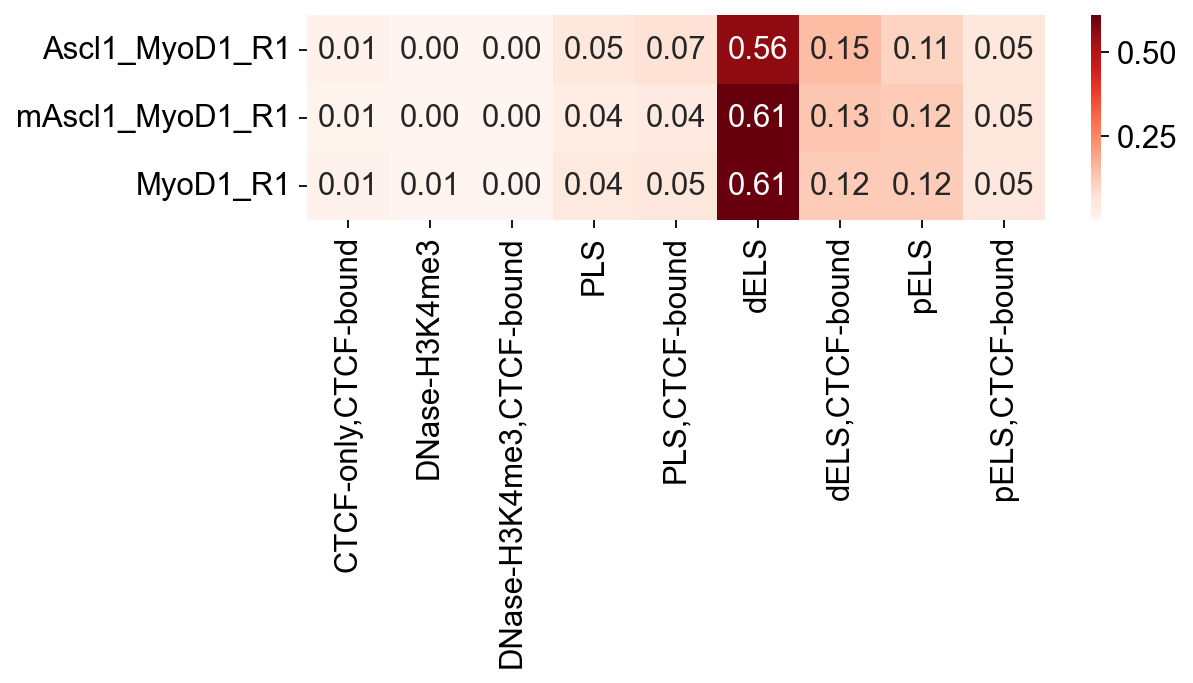

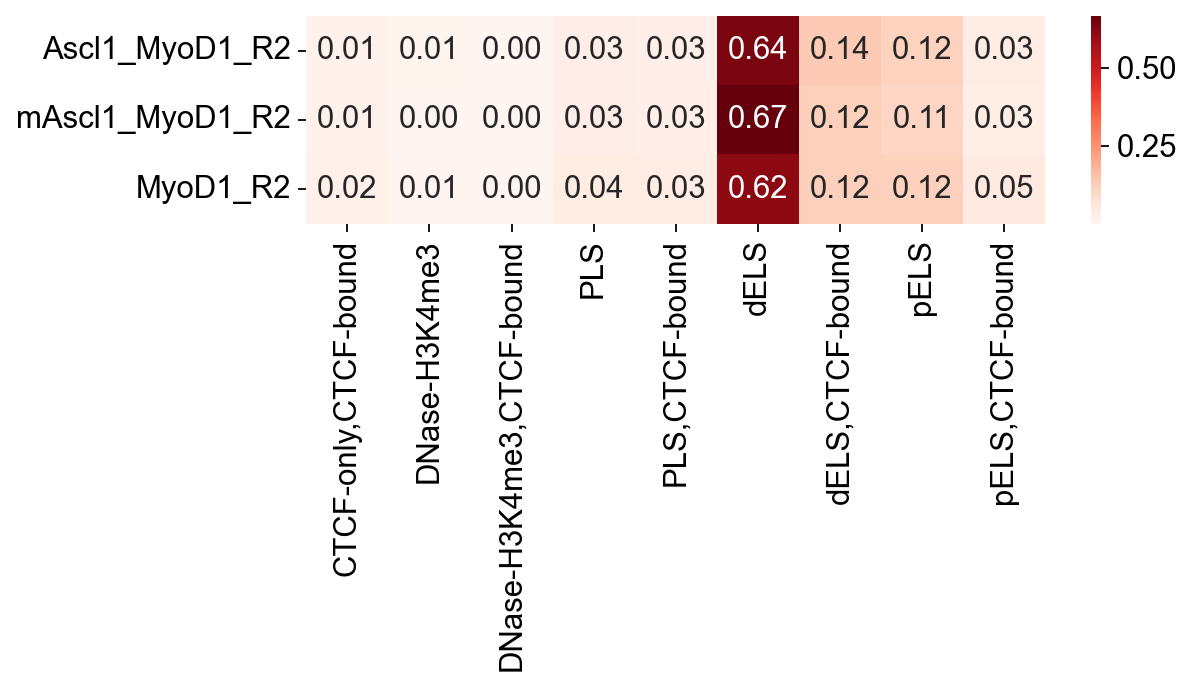

In [25]:
fig, ax = plt.subplots(1,1,figsize=(8,4.5))
mat = mat_overlaps.iloc[:3, :].copy()
mat = pd.DataFrame(
    mat.values / mat.values.sum(axis=1, keepdims=True),
    index=mat_overlaps.index[:3], columns=mat_overlaps.columns
)
sb.heatmap(mat, cmap="Reds", annot=True, fmt=".2f", ax=ax)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1,1,figsize=(8,4.5))
mat = mat_overlaps.iloc[3:, :].copy()
mat = pd.DataFrame(
    mat.values / mat.values.sum(axis=1, keepdims=True),
    index=mat_overlaps.index[3:], columns=mat_overlaps.columns
)
sb.heatmap(mat, cmap="Reds", annot=True, fmt=".2f", ax=ax)
plt.tight_layout()
plt.show()

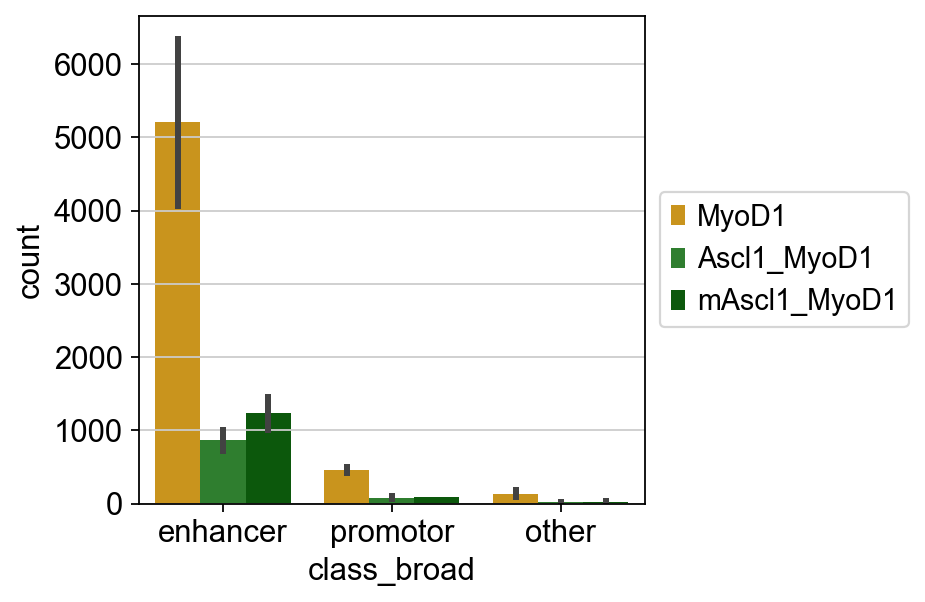

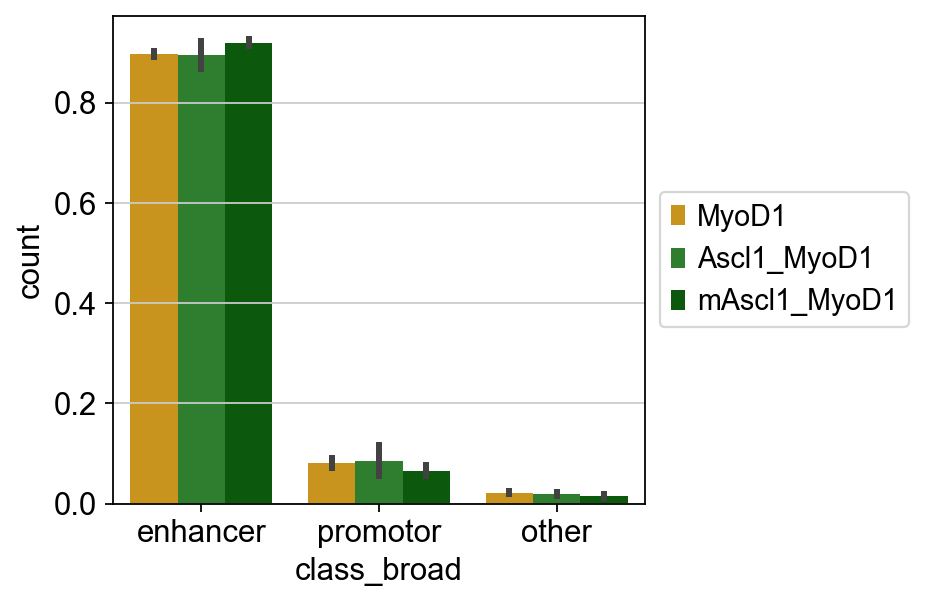

,class_broad,sample,count,condition
0,enhancer,Ascl1_MyoD1_R1,0.867066,Ascl1_MyoD1
1,enhancer,Ascl1_MyoD1_R2,0.923502,Ascl1_MyoD1
2,enhancer,MyoD1_R1,0.891300,MyoD1
3,enhancer,MyoD1_R2,0.903534,MyoD1
4,enhancer,mAscl1_MyoD1_R1,0.912297,mAscl1_MyoD1
5,enhancer,mAscl1_MyoD1_R2,0.926705,mAscl1_MyoD1
6,promotor,Ascl1_MyoD1_R1,0.117365,Ascl1_MyoD1
7,promotor,Ascl1_MyoD1_R2,0.054378,Ascl1_MyoD1
8,promotor,MyoD1_R1,0.090511,MyoD1
9,promotor,MyoD1_R2,0.070960,MyoD1


In [26]:
tab = pd.DataFrame(
    mat_overlaps,
    index=mat_overlaps.index, columns=mat_overlaps.columns
)
tab["sample"] = tab.index
tab = tab.melt(var_name="class", value_name="count", id_vars="sample")
tab["class_broad"] = pd.Categorical([
    {
        'CTCF-only,CTCF-bound': 'other', 
        'DNase-H3K4me3': 'other', 
        'DNase-H3K4me3,CTCF-bound': 'other',
        'PLS': 'promotor', 
        'PLS,CTCF-bound': 'promotor', 
        'dELS': 'enhancer', 
        'dELS,CTCF-bound': 'enhancer', 
        'pELS': 'enhancer',
        'pELS,CTCF-bound': 'enhancer',
    }[x] for x in tab["class"].values
], categories=['enhancer', "promotor", "other"])
tab_frac = (
    tab.groupby(["class_broad", "sample"])["count"].sum() / 
    tab.groupby(["sample"])["count"].sum()
).reset_index()
tab = tab.groupby(["class_broad", "sample"])["count"].sum().reset_index()
tab["condition"] = pd.Categorical(
    [x[:-3] for x in tab["sample"].values],
    categories=["MyoD1", "Ascl1_MyoD1", "mAscl1_MyoD1"])
tab_frac["condition"] = tab["condition"].values

fig, ax = plt.subplots(1,1,figsize=(6,4))
ax = sb.barplot(
    data=tab, 
    x="class_broad", y="count", hue="condition", 
    palette=["#E69F00", "forestgreen", 'darkgreen'], ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1,1,figsize=(6,4))
ax = sb.barplot(
    data=tab_frac, 
    x="class_broad", y="count", hue="condition", 
    palette=["#E69F00", "forestgreen", 'darkgreen'], ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(dir_out + "6h.pdf")
plt.show()

tab_frac

## Overlap to CHIP Myod1

overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5', 'chr3', 'chr10', 'chr11', 'chr2', 'chr4', 'chr19', 'chr8', 'chr1', 'chr6', 'chr18', 'chrx', 'chr16'}
non-overlapping chromsomes: {'chrun_jh584304', 'chr4_gl456216_random', 'chrmt', 'chrun_gl456389', 'chrun_gl456392'}
overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5', 'chr3', 'chr10', 'chr11', 'chr2', 'chr4', 'chr19', 'chr8', 'chr1', 'chr6', 'chr18', 'chrx', 'chr16'}
non-overlapping chromsomes: {'chrun_jh584304', 'chr4_gl456216_random', 'chrmt', 'chrun_gl456389', 'chrun_gl456392'}
overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chrmt', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5', 'chr3', 'chr10', 'chr11', 'chr2', 'chr4', 'chr19', 'chr8', 'chr1', 'chr6', 'chr18', 'chrx', 'chr16'}
non-overlapping chromsomes: {'chrun_jh584304', 'chr4_gl456216_random', 'chrun_gl456389', 'chrun_gl456392'}
overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13'

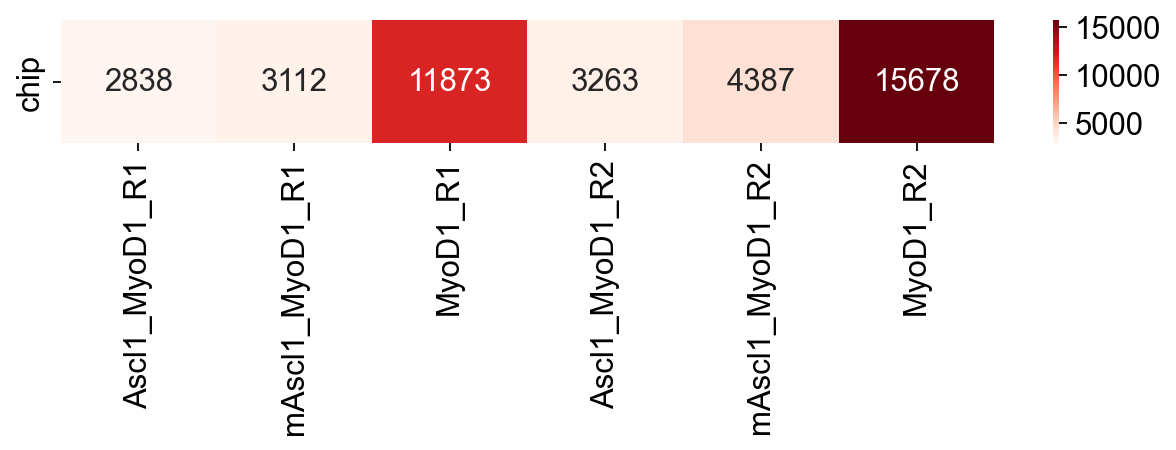

,Ascl1_MyoD1_R1,mAscl1_MyoD1_R1,MyoD1_R1,Ascl1_MyoD1_R2,mAscl1_MyoD1_R2,MyoD1_R2
chip,2838,3112,11873,3263,4387,15678


In [27]:
mat_overlaps = pd.DataFrame(np.zeros((1, 6), dtype="int"), 
                            index=["chip"], 
                            columns=list(peaks_diff2.keys()))
for k1, v1 in {
    "chip": tftools.reading.LoaderChipseqBed(fn=fn_myod1_chip)
}.items():
    for k2, v2 in peaks_diff2.items():
        key_bed = v1
        tftools.overlaps.OverlapBedBed(bed_key=key_bed, bed_query=v2).query(cumulative=True)
        mat_overlaps.loc[k1, k2] = int(np.sum(key_bed.tab["matches"].values > 0))
fig, ax = plt.subplots(1,1,figsize=(8,3))
sb.heatmap(mat_overlaps, cmap="Reds", annot=True, fmt=".0f", ax=ax)
plt.tight_layout()
plt.show()
mat_overlaps

# ATAC analysis

## Conditions

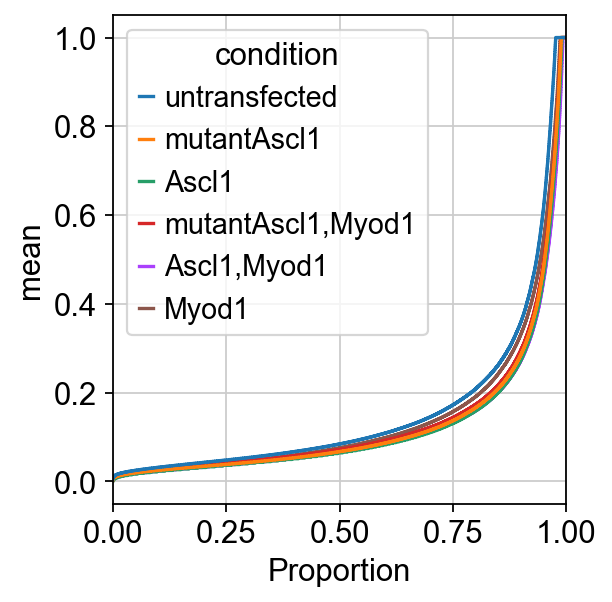

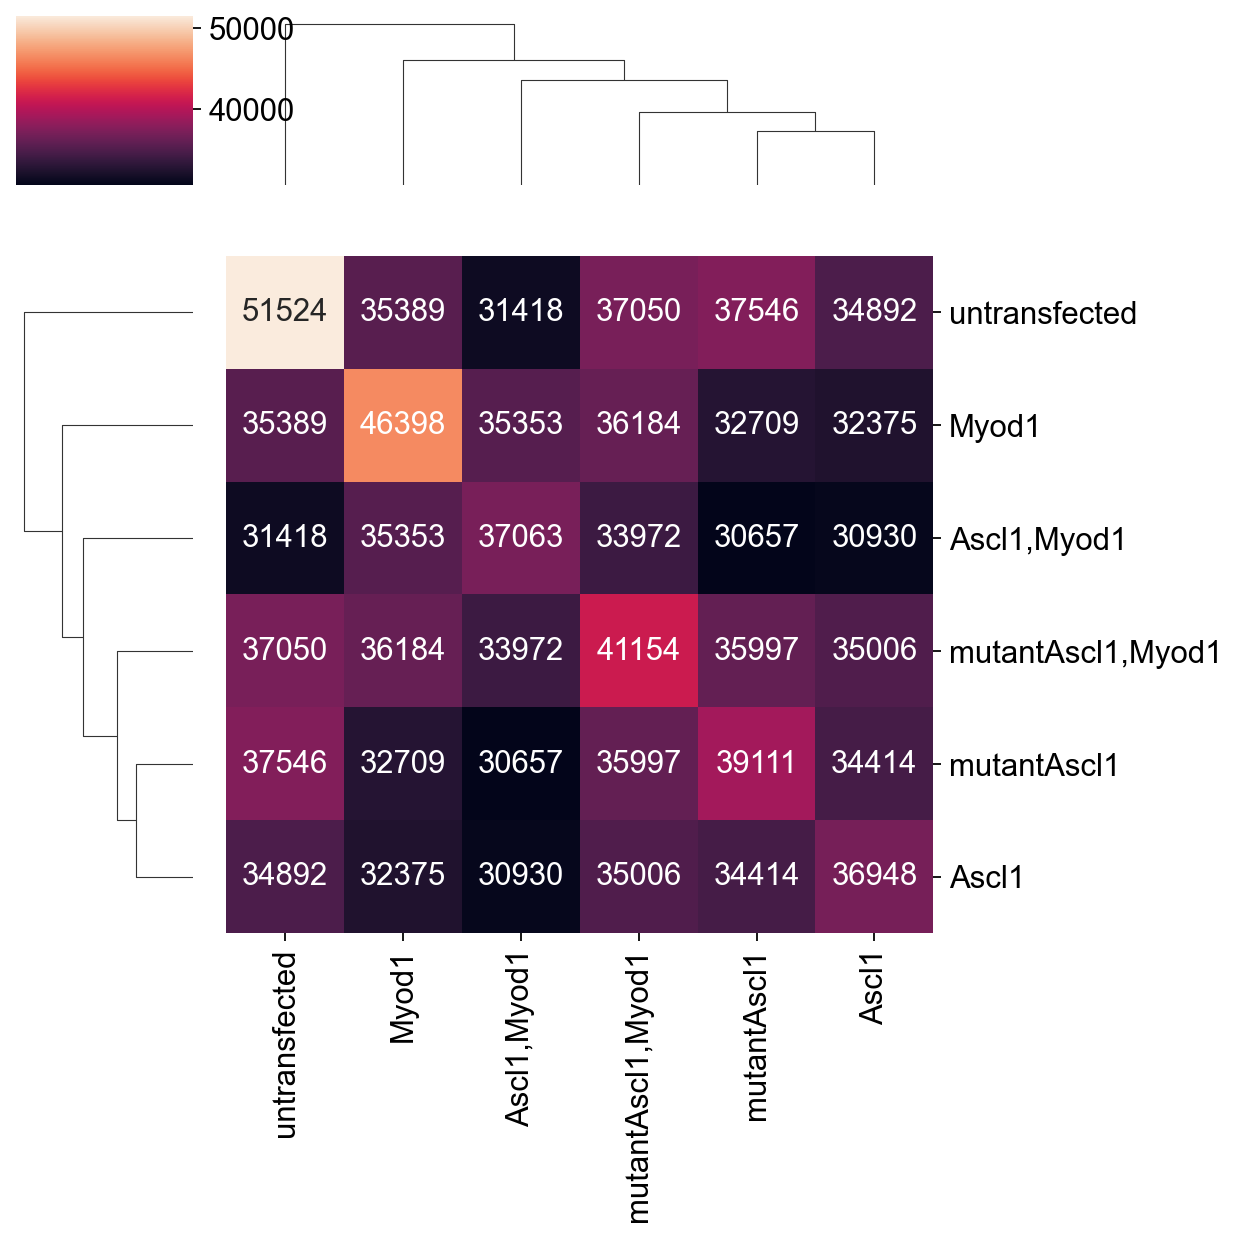

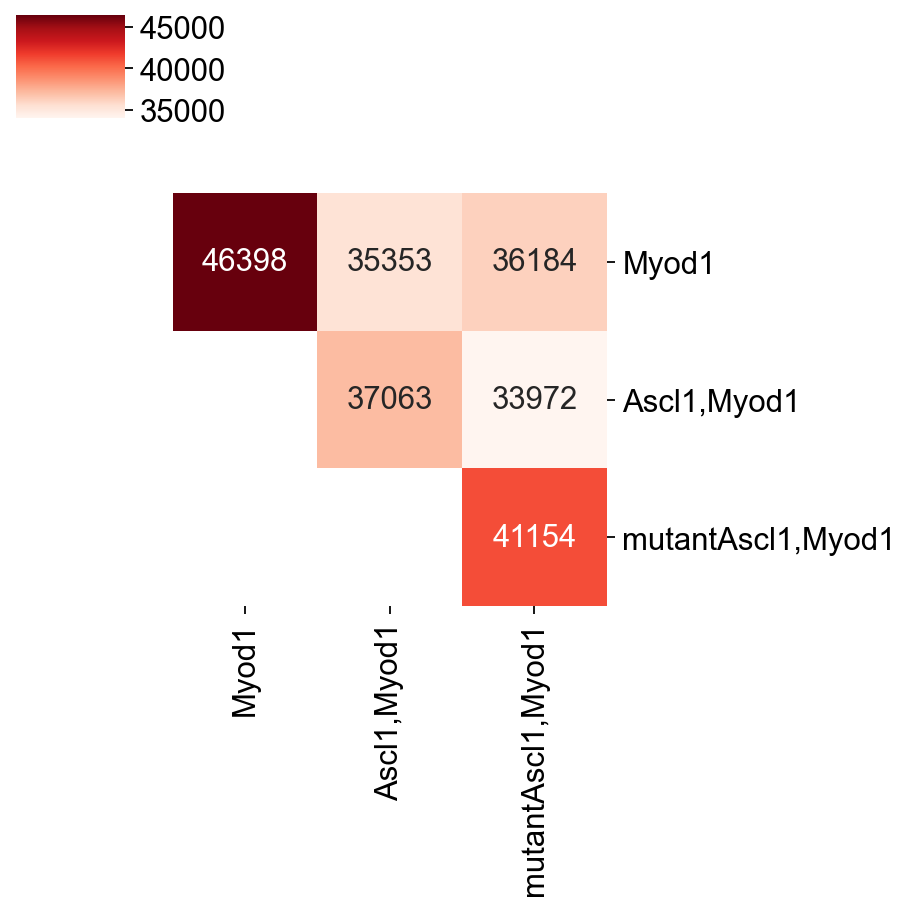

In [28]:
groups = ['untransfected', 'mutantAscl1', 'Ascl1', 'mutantAscl1,Myod1', 
          'Ascl1,Myod1', 'Myod1']

tab_peaks_condition = pd.concat([
    pd.DataFrame(
        np.asarray(adata_atac_proc2[
            adata_atac_proc2.obs["inferred_category_real"].values == x, :
        ].X.mean(axis=0)).flatten(),
        index=adata_atac_proc2.var_names,
        columns=[x],
    ) for x in groups
], axis=1)

tab = tab_peaks_condition.melt(var_name="condition", value_name="mean")
tab["mean"] = np.minimum(
    tab["mean"].values, 
    np.ones_like(tab["mean"].values))
sb.ecdfplot(data=tab, hue="condition", y="mean")
plt.tight_layout()
plt.show()

tab = np.asarray(tab_peaks_condition.values > 0.2, "int32")
tab = np.matmul(tab.T, tab)
tab = pd.DataFrame(tab, index=tab_peaks_condition.columns, 
                   columns=tab_peaks_condition.columns)

sb.clustermap(tab, annot=True, fmt=".0f", figsize=(8, 8))
plt.tight_layout()
plt.show()

subset = ["Myod1", "Ascl1,Myod1", "mutantAscl1,Myod1"]
tab = np.asarray(tab_peaks_condition[subset].values > 0.2, "float32")
tab = np.matmul(tab.T, tab)
tab = np.triu(tab)
tab[tab == 0] = np.nan

tab = pd.DataFrame(tab, index=subset, columns=subset)

sb.clustermap(tab, row_cluster=False, col_cluster=False, annot=True, 
              fmt=".0f", cmap="Reds", figsize=(6, 6))
plt.tight_layout()
plt.savefig(dir_out + "EV5f.pdf")
plt.show()

# CutNRUn - ATAC analysis

## Cutnrun coverage by ATAC

Compare set of scATAC peaks with CutNRun peaks.

overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5', 'chr3', 'chr10', 'chr11', 'chr2', 'chr4', 'chr19', 'chr8', 'chr1', 'chr6', 'chr18', 'chrx', 'chr16'}
non-overlapping chromsomes: {'chrjh584295.1', 'chrjh584304.1', 'chrgl456216.1', 'chry', 'chrgl456233.1'}
overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5', 'chr3', 'chr10', 'chr11', 'chr2', 'chr4', 'chr19', 'chr8', 'chr1', 'chr6', 'chr18', 'chrx', 'chr16'}
non-overlapping chromsomes: {'chrjh584295.1', 'chrjh584304.1', 'chrgl456216.1', 'chry', 'chrgl456233.1'}
overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5', 'chr3', 'chr10', 'chr11', 'chr2', 'chr4', 'chr19', 'chr8', 'chr1', 'chr6', 'chr18', 'chrx', 'chr16'}
non-overlapping chromsomes: {'chrjh584295.1', 'chrmt', 'chrjh584304.1', 'chrgl456216.1', 'chry', 'chrgl456233.1'}
overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5

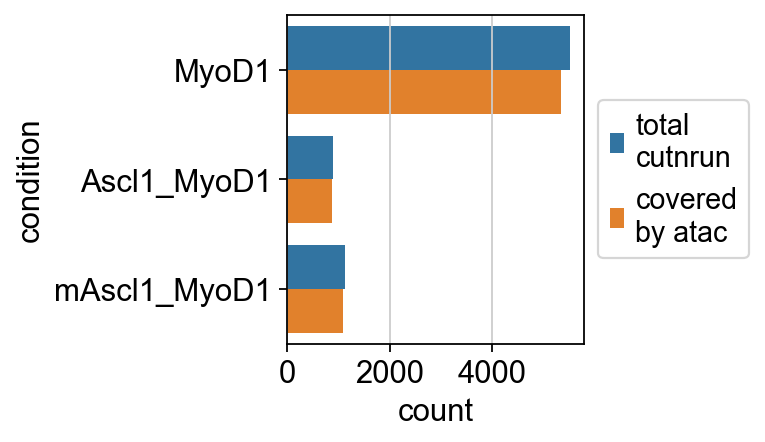

                                           condition    sample rep  \
MyoD1_sample_0_total\ncutnrun                  MyoD1  sample_0  R1   
Ascl1_MyoD1_sample_0_total\ncutnrun      Ascl1_MyoD1  sample_0  R1   
mAscl1_MyoD1_sample_0_total\ncutnrun    mAscl1_MyoD1  sample_0  R1   
MyoD1_sample_0_covered\nby atac                MyoD1  sample_0  R1   
Ascl1_MyoD1_sample_0_covered\nby atac    Ascl1_MyoD1  sample_0  R1   
mAscl1_MyoD1_sample_0_covered\nby atac  mAscl1_MyoD1  sample_0  R1   

                                                    type  count  
MyoD1_sample_0_total\ncutnrun             total\ncutnrun   5521  
Ascl1_MyoD1_sample_0_total\ncutnrun       total\ncutnrun    901  
mAscl1_MyoD1_sample_0_total\ncutnrun      total\ncutnrun   1123  
MyoD1_sample_0_covered\nby atac         covered\nby atac   5355  
Ascl1_MyoD1_sample_0_covered\nby atac   covered\nby atac    879  
mAscl1_MyoD1_sample_0_covered\nby atac  covered\nby atac   1093  


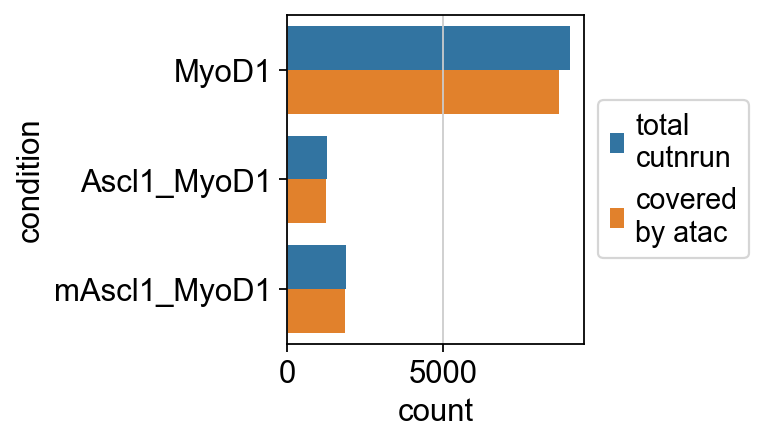

                                           condition    sample rep  \
MyoD1_sample_0_total\ncutnrun                  MyoD1  sample_0  R2   
Ascl1_MyoD1_sample_0_total\ncutnrun      Ascl1_MyoD1  sample_0  R2   
mAscl1_MyoD1_sample_0_total\ncutnrun    mAscl1_MyoD1  sample_0  R2   
MyoD1_sample_0_covered\nby atac                MyoD1  sample_0  R2   
Ascl1_MyoD1_sample_0_covered\nby atac    Ascl1_MyoD1  sample_0  R2   
mAscl1_MyoD1_sample_0_covered\nby atac  mAscl1_MyoD1  sample_0  R2   

                                                    type  count  
MyoD1_sample_0_total\ncutnrun             total\ncutnrun   9059  
Ascl1_MyoD1_sample_0_total\ncutnrun       total\ncutnrun   1275  
mAscl1_MyoD1_sample_0_total\ncutnrun      total\ncutnrun   1880  
MyoD1_sample_0_covered\nby atac         covered\nby atac   8722  
Ascl1_MyoD1_sample_0_covered\nby atac   covered\nby atac   1247  
mAscl1_MyoD1_sample_0_covered\nby atac  covered\nby atac   1846  


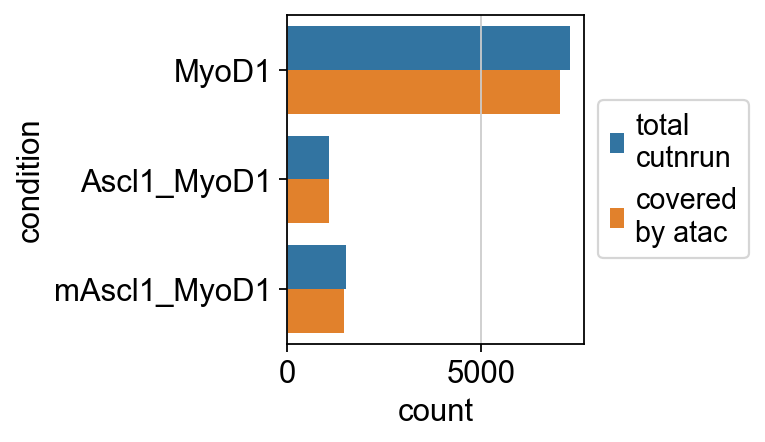

In [29]:
mat_overlaps = {}
conds = ["MyoD1", "Ascl1_MyoD1", "mAscl1_MyoD1"]
for r in ["R1", "R2"]:
    mat_overlaps[r] = []
    for i, (k, bed_atac) in enumerate(peaks_atac.items()):
        temp = pd.DataFrame(
            np.zeros((3,2), dtype="int"), 
            index=conds, 
            columns=["total\ncutnrun", "covered\nby atac"])
        for k1, v1 in [(k1, v1) for k1, v1 in peaks_diff2.items() if k1.endswith(r)]:
            key_bed = v1
            temp.loc[k1.split("_R")[0], "total\ncutnrun"] = key_bed.tab["matches"].shape[0]
            tftools.overlaps.OverlapBedBed(bed_key=key_bed, bed_query=bed_atac).query(cumulative=True)
            temp.loc[k1.split("_R")[0], "covered\nby atac"] = int(np.sum(key_bed.tab["matches"].values > 0))
        temp["sample"] = k
        mat_overlaps[r].append(temp)
    mat_overlaps[r] = pd.concat(mat_overlaps[r], axis=0)
    mat_overlaps[r]["rep"] = r
    mat_overlaps[r]["condition"] = [x.split("_R")[0] for x in mat_overlaps[r].index.tolist()]
    mat_overlaps[r] = mat_overlaps[r].melt(var_name="type", value_name="count", 
                                           id_vars=["condition", "sample", "rep"])
    mat_overlaps[r].index = [f"{x}_{y}_{z}" for x, y, z in zip(
        mat_overlaps[r]["condition"].values,
        mat_overlaps[r]["sample"].values,
        mat_overlaps[r]["type"].values,
    )]

for k, v in mat_overlaps.items():
    fig, ax = plt.subplots(1,1, figsize=(5, 3))
    sb.barplot(data=v, y="condition", x="count", hue="type", ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.savefig(dir_out + f"EV5e_{k}.pdf")
    plt.show()
    print(v)
    
mat_overlaps_ave = mat_overlaps["R1"]
mat_overlaps_ave["count"] = (
    mat_overlaps_ave["count"].values + 
    mat_overlaps["R2"].loc[mat_overlaps_ave.index, "count"].values
) / 2.
fig, ax = plt.subplots(1,1, figsize=(5, 3))
sb.barplot(data=mat_overlaps_ave, y="condition", x="count", hue="type", ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.tight_layout()
plt.savefig(dir_out + "6j.pdf")
plt.show()

## Overlap to DE gene sets

In [30]:
genes_cutnrun = {}
for k, v in peaks_diff2.items():
    tftools.overlaps.OverlapBedBed(
        bed_key=v, 
        bed_query=peaks_atac["sample_0"]).query(cumulative=False)
    tab = v.tab.copy()
    tab = tab.loc[[x != "None" for x in tab["matches"].values], :]
    # Look up first matched gene association in ATAC table:
    tab["gene"] = [
        peaks_atac["sample_0"].tab.loc[x.split(",")[0], "gene"]
        for x in tab["matches"].values]
    genes_cutnrun[k] = np.unique([
        xx.lower() for x in tab["gene"].values if x is not np.nan for xx in x.split(",")
    ])

overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5', 'chr3', 'chr10', 'chr11', 'chr2', 'chr4', 'chr19', 'chr8', 'chr1', 'chr6', 'chr18', 'chrx', 'chr16'}
non-overlapping chromsomes: {'chrjh584295.1', 'chrjh584304.1', 'chrgl456216.1', 'chry', 'chrgl456233.1'}
overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5', 'chr3', 'chr10', 'chr11', 'chr2', 'chr4', 'chr19', 'chr8', 'chr1', 'chr6', 'chr18', 'chrx', 'chr16'}
non-overlapping chromsomes: {'chrjh584295.1', 'chrjh584304.1', 'chrgl456216.1', 'chry', 'chrgl456233.1'}
overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5', 'chr3', 'chr10', 'chr11', 'chr2', 'chr4', 'chr19', 'chr8', 'chr1', 'chr6', 'chr18', 'chrx', 'chr16'}
non-overlapping chromsomes: {'chrjh584295.1', 'chrmt', 'chrjh584304.1', 'chrgl456216.1', 'chry', 'chrgl456233.1'}
overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5

In [31]:
# Summarize lists over replicates:
genes_cutnrun_union = {}
for x in ['Ascl1_MyoD1', 'mAscl1_MyoD1', 'MyoD1']:
    genes_cutnrun_union[x] = np.sort(np.unique(np.concatenate([
        v for k, v in genes_cutnrun.items()
        if k.startswith(x)
    ])))

In [32]:
pd.DataFrame({"genes": genes_cutnrun_union["MyoD1"]}).to_csv(dir_tables + "fig6_cutnrun_genes_Myod1.csv", sep=";")

Load DE genes from III_new_tf_3:

In [33]:
de_up = {}
de_down = {}
de_genes = {}

for k in ['Myod1', "Ascl1_Myod1"]:
    de_up[k] = pd.read_csv(dir_tables_new_tf + f"new_tf_de_{k}_up.csv")
    de_down[k] = pd.read_csv(dir_tables_new_tf + f"new_tf_de_{k}_down.csv")
    de_genes[k] = {
        "up": de_up[k]["gene"].values,
        "down": de_down[k]["gene"].values,}

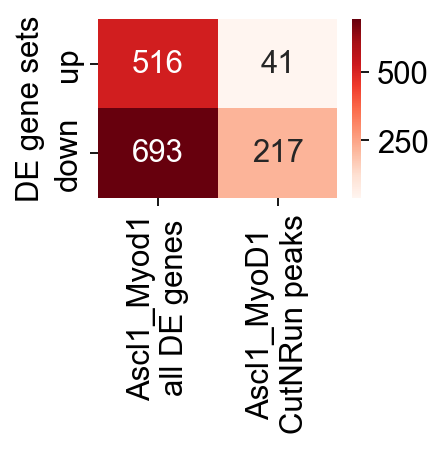

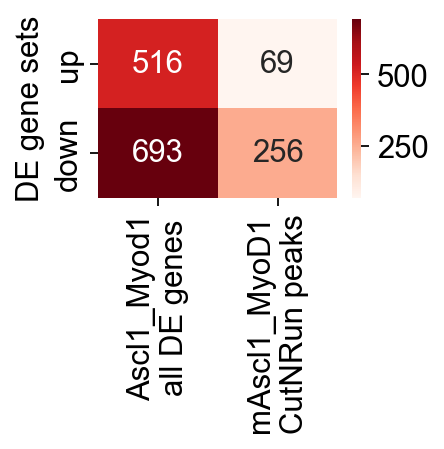

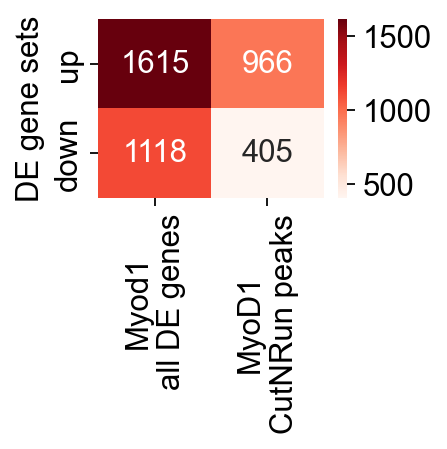

In [34]:
for k, v in genes_cutnrun_union.items():
    mat = np.zeros((2, 2))
    kde = {
        "MyoD1": "Myod1", 
        "mAscl1_MyoD1": "Ascl1_Myod1",
        "Ascl1_MyoD1": "Ascl1_Myod1",
    }[k]
    temp = de_genes[kde]
    for i, (kk, vv) in enumerate(temp.items()):
        mat[i, 0] = len(vv)
        mat[i, 1] = len(set(v).intersection(set(vv)))
    tab = pd.DataFrame(
        mat, 
        columns=[f"{kde}\nall DE genes", f"{k}\nCutNRun peaks"],
        index=temp.keys())
    fig, ax = plt.subplots(1,1, figsize=(3, 3))
    sb.heatmap(tab, cmap="Reds", annot=True, fmt=".0f", ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("DE gene sets")
    ax.set_title("")
    plt.tight_layout()
    plt.show()

In [35]:
scores = {}
for k, v in peaks_diff2.items():
    v.extend_windows(start_by=-10000, end_by=10000)
    scores[k] = {}
    tftools.overlaps.OverlapBedBed(
        bed_key=v, 
        bed_query=peaks_atac["sample_0"]).query(cumulative=False)
    tab = v.tab.copy()
    tab = tab.loc[[x != "None" for x in tab["matches"].values], :]
    # Look up first matched gene association in ATAC table:
    tab["gene"] = [
        peaks_atac["sample_0"].tab.loc[x.split(",")[0], "gene"]
        for x in tab["matches"].values]
    for x in np.unique([x for x in tab["gene"].values if isinstance(x, str)]):
        for xx in x.lower().split(","):
            if xx not in scores[k].keys():
                scores[k][xx] = 0
            scores[k][xx] += np.sum(tab.loc[tab["gene"].values == x, "score"].values)

overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5', 'chr3', 'chr10', 'chr11', 'chr2', 'chr4', 'chr19', 'chr8', 'chr1', 'chr6', 'chr18', 'chrx', 'chr16'}
non-overlapping chromsomes: {'chrjh584295.1', 'chrjh584304.1', 'chrgl456216.1', 'chry', 'chrgl456233.1'}
overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5', 'chr3', 'chr10', 'chr11', 'chr2', 'chr4', 'chr19', 'chr8', 'chr1', 'chr6', 'chr18', 'chrx', 'chr16'}
non-overlapping chromsomes: {'chrjh584295.1', 'chrjh584304.1', 'chrgl456216.1', 'chry', 'chrgl456233.1'}
overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5', 'chr3', 'chr10', 'chr11', 'chr2', 'chr4', 'chr19', 'chr8', 'chr1', 'chr6', 'chr18', 'chrx', 'chr16'}
non-overlapping chromsomes: {'chrjh584295.1', 'chrmt', 'chrjh584304.1', 'chrgl456216.1', 'chry', 'chrgl456233.1'}
overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5

In [36]:
targets = ['myog', 'des', 'mef2c', 'tnni1', 'mylpf', 'pitx3', 'zbtb18']
tab1 = pd.concat([
    pd.concat([
        pd.concat([
            pd.DataFrame({
                "value": [np.log(scores[{
                    "Myod1": f"MyoD1_{r}", 
                    "mutantAscl1,Myod1": f"mAscl1_MyoD1_{r}",
                    "Ascl1,Myod1": f"Ascl1_MyoD1_{r}",
                }[z]][y]+1) if z in {
                    "Myod1": f"MyoD1_{r}", 
                    "mutantAscl1,Myod1": f"mAscl1_MyoD1_{r}",
                    "Ascl1,Myod1": f"Ascl1_MyoD1_{r}",
                }.keys() and y in scores[{
                    "Myod1": f"MyoD1_{r}", 
                    "mutantAscl1,Myod1": f"mAscl1_MyoD1_{r}",
                    "Ascl1,Myod1": f"Ascl1_MyoD1_{r}",
                }[z]].keys() else 0],
                "run": r,
                "condition": {
                    "Myod1": "MyoD1", 
                    "mutantAscl1,Myod1": "mAscl1, MyoD1",
                    "Ascl1,Myod1": "Ascl1, MyoD1",
                }[z],
                "modality": "CUT&Run",
                "gene": y,
            })
            for r in ["R1", "R2"]
        ], axis=0)
        for y in targets
    ], axis=0)
    for z in ["Myod1", "Ascl1,Myod1", "mutantAscl1,Myod1"]
], axis=0)
tab2 = pd.concat([
    pd.concat([
        pd.concat([
            pd.concat([
                pd.DataFrame({
                    "value": np.minimum(
                        np.log(np.asarray(adata_atac_proc2.raw[adata_rna_proc2.obs_names[adata_rna_proc2.obs["louvain_coarse"].values == z], :][:, [y in str(yy).lower() for yy in adata_atac_proc2.raw.var["gene"].values]].X.mean(axis=1)).flatten() + 1.) / 
                            np.quantile(np.log(np.asarray(adata_atac_proc2.raw[:, [y in str(yy).lower() for yy in adata_atac_proc2.raw.var["gene"].values]].X.mean(axis=1)).flatten() + 1.), 0.98),
                        1.
                    ),
                    "condition": z,
                    "modality": "ATAC",
                    "gene": y,
                }),
                pd.DataFrame({
                    "value": np.asarray(adata_rna_proc2[adata_rna_proc2.obs["louvain_coarse"].values == z, y].X.todense()).flatten(),
                    "condition": z,
                    "modality": "RNA",
                    "gene": y,
                })
            ], axis=0)
            for z in ["myogenic", "collision", "control"]
        ], axis=0)
    ], axis=0)
    for y in targets
], axis=0)
tab1["condition"] = pd.Categorical(tab1["condition"].values, categories=["MyoD1", "Ascl1, MyoD1", "mAscl1, MyoD1"])
tab2["condition"] = pd.Categorical(tab2["condition"].values, categories=["myogenic", "collision", "control"])

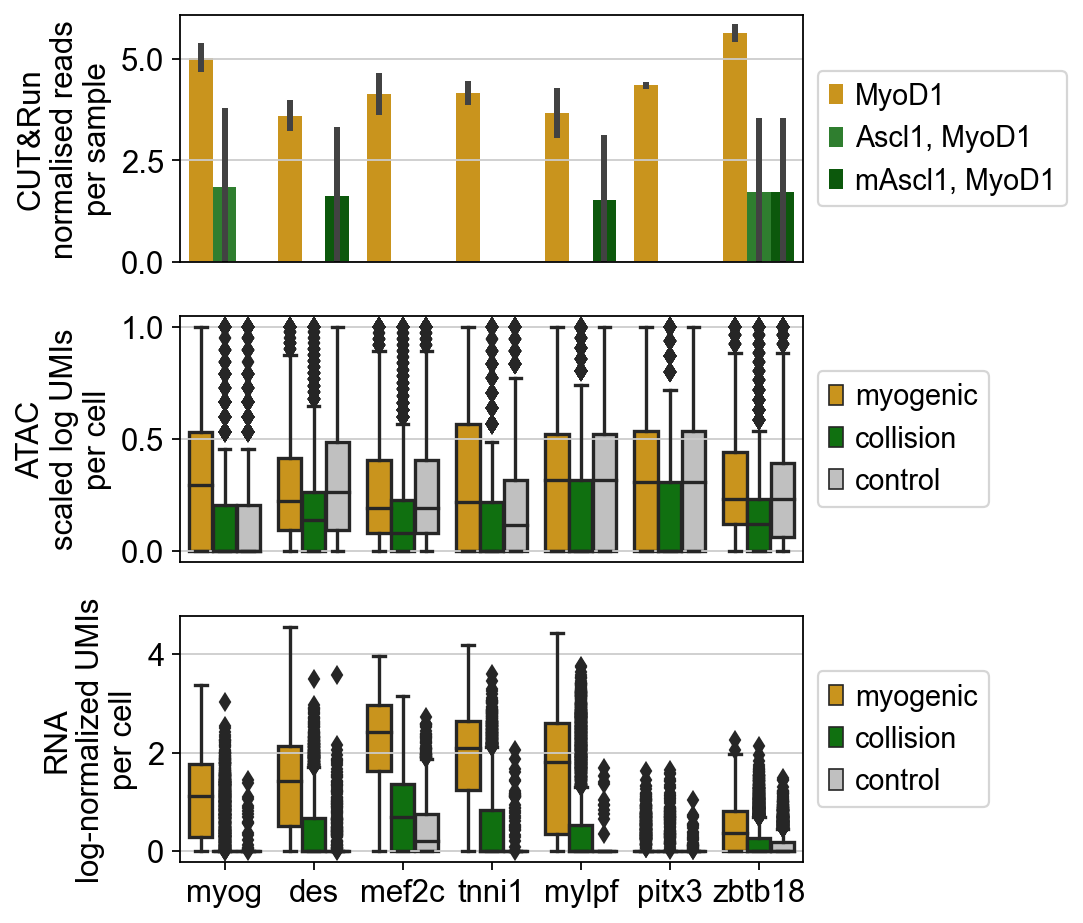

In [37]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7,6))
sb.barplot(
    data=tab1, palette=["#E69F00", "forestgreen", 'darkgreen'],
    x="gene", y="value", hue="condition", ax=axs[0])
sb.boxplot(
    data=tab2.loc[tab2["modality"].values == "ATAC", :],
    palette=["#E69F00", "green", 'silver'],
    x="gene", y="value", hue="condition", ax=axs[1])
sb.boxplot(
    data=tab2.loc[tab2["modality"].values == "RNA", :], 
    palette=["#E69F00", "green", 'silver'],
    x="gene", y="value", hue="condition", ax=axs[2])
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[0].set_xlabel("")
axs[1].set_xlabel("")
axs[2].set_xlabel("")
axs[0].set_xticks([])
axs[1].set_xticks([])
axs[0].set_ylabel("CUT&Run\nnormalised reads\nper sample")
axs[1].set_ylabel("ATAC\nscaled log UMIs\nper cell")
axs[2].set_ylabel("RNA\nlog-normalized UMIs\nper cell")
plt.tight_layout()
plt.savefig(dir_out+ "6k.pdf")
plt.show()

## Overlap cutnrun to condition-wise atac peaks

In [38]:
# precompute overlapping peaks
atac_peak_features = {}
for kk, vv in peaks_atac.items():
    atac_peak_features[kk] = {}
    cutnrun = dict([(k, tftools.reading.LoaderChipseqBed(v)) 
                    for k, v in fn_cutnrun2_diff.items()])
    for k, v in cutnrun.items():
        tftools.overlaps.OverlapBedBed(bed_key=vv, bed_query=v).query(cumulative=True)
        atac_peak_features[kk][k] = vv.tab.loc[vv.tab["matches"] > 0, vv.colname_element_id].values

overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5', 'chr3', 'chr10', 'chr11', 'chr2', 'chr4', 'chr19', 'chr8', 'chr1', 'chr6', 'chr18', 'chrx', 'chr16'}
non-overlapping chromsomes: {'chrjh584295.1', 'chrjh584304.1', 'chrgl456216.1', 'chry', 'chrgl456233.1'}
overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5', 'chr3', 'chr10', 'chr11', 'chr2', 'chr4', 'chr19', 'chr8', 'chr1', 'chr6', 'chr18', 'chrx', 'chr16'}
non-overlapping chromsomes: {'chrjh584295.1', 'chrjh584304.1', 'chrgl456216.1', 'chry', 'chrgl456233.1'}
overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5', 'chr3', 'chr10', 'chr11', 'chr2', 'chr4', 'chr19', 'chr8', 'chr1', 'chr6', 'chr18', 'chrx', 'chr16'}
non-overlapping chromsomes: {'chrjh584295.1', 'chrmt', 'chrjh584304.1', 'chrgl456216.1', 'chry', 'chrgl456233.1'}
overlapping chromsomes: {'chr12', 'chr15', 'chr9', 'chr14', 'chr13', 'chr17', 'chr7', 'chr5

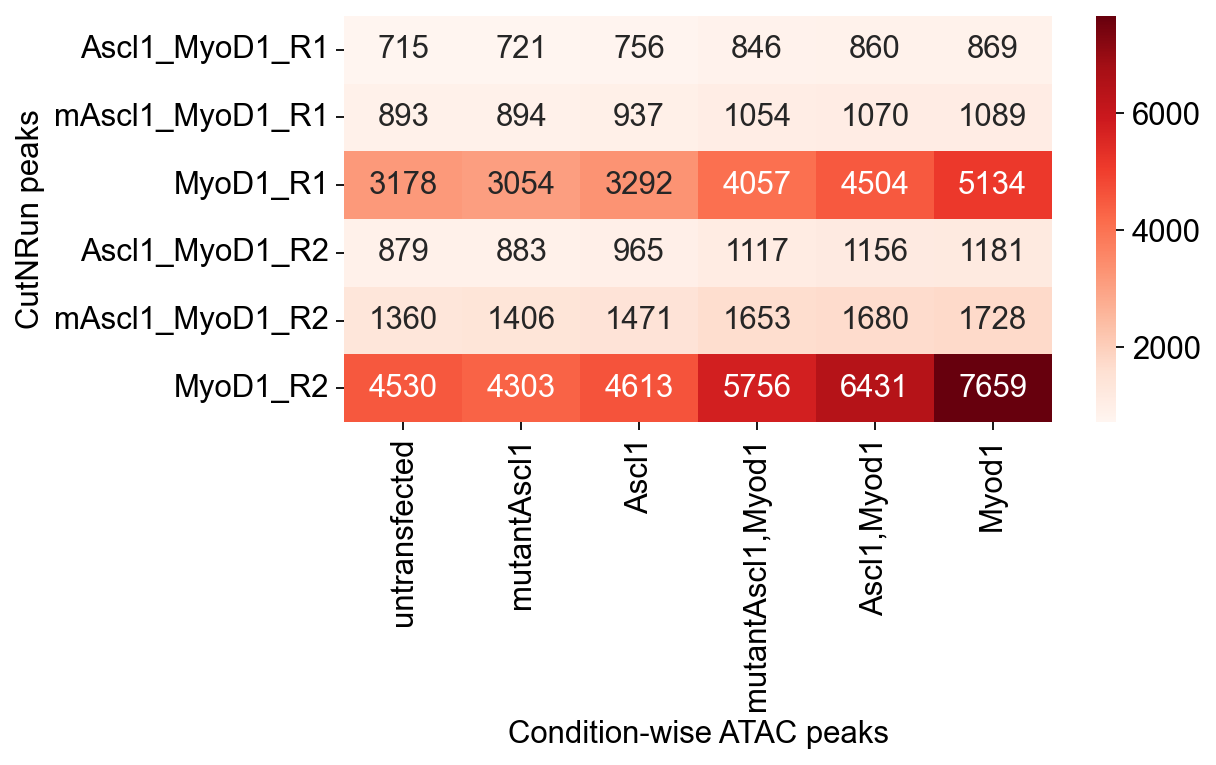

In [47]:
groups = ['untransfected', 'mutantAscl1', 'Ascl1', 'mutantAscl1,Myod1', 
          'Ascl1,Myod1', 'Myod1']
mat_overlaps = np.zeros((1, 6, len(groups)))
for i, (k, v) in enumerate(atac_peak_features.items()):
    for iii, x in enumerate(groups):
        if i == 0:
            adata = adata_atac_proc2
        else:
            assert False
        tab_peaks_condition = pd.concat([
            pd.DataFrame(
                np.asarray(adata[
                    adata.obs["inferred_category_real"].values == x, :
                ].X.mean(axis=0)).flatten(),
                index=adata.var_names,
                columns=[x],
            ) for x in groups
        ], axis=1)
        target_features = tab_peaks_condition.index[
            tab_peaks_condition[x].values > 0.2
        ]
        target_features = ["chr" + "-".join(z.split(":")) for z in target_features]
        for ii, (kk, vv) in enumerate(v.items()):
            mat_overlaps[i, ii, iii] = len(set(target_features).intersection(set(vv)))

tab = pd.DataFrame(
    mat_overlaps[0], 
    columns=groups,
    index=atac_peak_features["sample_0"].keys())
fig, ax = plt.subplots(1,1, figsize=(8, 5))
sb.heatmap(tab, cmap="Reds", annot=True, fmt=".0f", ax=ax)
ax.set_ylabel("CutNRun peaks")
ax.set_xlabel("Condition-wise ATAC peaks")
plt.tight_layout()
plt.show()

# ATAC - CutNRun - DE

Compute differential genes between DP and SP:

In [48]:
cond_de_genes = {}
cond_up_genes = {}
cond_down_genes = {}
for genotype1 in ["untransfected", "Ascl1,Myod1", "mutantAscl1,Myod1", "Myod1"]:
    cond_de_genes[genotype1] = {}
    cond_up_genes[genotype1] = {}
    cond_down_genes[genotype1] = {}
    for genotype2 in ["untransfected", "Ascl1,Myod1", "mutantAscl1,Myod1", "Myod1"]:
        print(f"{genotype1}: {genotype2}")
        if genotype1 != genotype2:
            a_temp1 = adata_rna_proc2[np.concatenate([
                np.where([
                    x in [genotype1] for x in adata_rna_proc2.obs["inferred_category_real"].values
                ])[0],
                np.where([
                    x in [genotype2] for x in adata_rna_proc2.obs["inferred_category_real"].values
                ])[0],
            ]), :].copy()
            det1 = de.test.t_test(
                a_temp1, 
                grouping="inferred_category_real")
            tab1 = det1.summary()
            ordered = np.unique([genotype1, genotype2]).tolist().index(genotype1) == 0
            de_genes = tab1["gene"].values[np.logical_and(
                tab1["qval"].values < 1e-2,
                np.logical_and(
                    np.abs(tab1["log2fc"].values) > 0,
                    tab1["mean"].values > 0.1,
                )
            )].tolist()
            down_genes = tab1["gene"].values[np.logical_and(
                tab1["qval"].values < 1e-2,
                np.logical_and(
                    tab1["log2fc"].values < 0 if ordered else tab1["log2fc"].values > 0,
                    tab1["mean"].values > 0.1,
                )
            )].tolist()
            up_genes = tab1["gene"].values[np.logical_and(
                tab1["qval"].values < 1e-2,
                np.logical_and(
                    tab1["log2fc"].values > 0 if ordered else tab1["log2fc"].values < 0,
                    tab1["mean"].values > 0.1,
                )
            )].tolist()
            # Sanity check that conditions (and LFC) are ordered correctly
            assert np.mean(a_temp1[a_temp1.obs["inferred_category_real"].values == genotype1, up_genes].X) < \
                np.mean(a_temp1[a_temp1.obs["inferred_category_real"].values == genotype2, up_genes].X)
            assert np.mean(a_temp1[a_temp1.obs["inferred_category_real"].values == genotype1, down_genes].X) > \
                np.mean(a_temp1[a_temp1.obs["inferred_category_real"].values == genotype2, down_genes].X)
            cond_de_genes[genotype1][genotype2] = de_genes
            cond_up_genes[genotype1][genotype2] = down_genes
            cond_down_genes[genotype1][genotype2] = up_genes

untransfected: untransfected
untransfected: Ascl1,Myod1
untransfected: mutantAscl1,Myod1
untransfected: Myod1
Ascl1,Myod1: untransfected
Ascl1,Myod1: Ascl1,Myod1
Ascl1,Myod1: mutantAscl1,Myod1
Ascl1,Myod1: Myod1
mutantAscl1,Myod1: untransfected
mutantAscl1,Myod1: Ascl1,Myod1
mutantAscl1,Myod1: mutantAscl1,Myod1
mutantAscl1,Myod1: Myod1
Myod1: untransfected
Myod1: Ascl1,Myod1
Myod1: mutantAscl1,Myod1
Myod1: Myod1


## DP comparison

CUT&Run: Bound by 'Ascl1,Myod1', 'mutantAscl1,Myod1'

GEX: 

    - down-regulated in 'Ascl1,Myod1' versus 'mutantAscl1,Myod1'
    - up-regulated in 'Ascl1,Myod1' versus 'mutantAscl1,Myod1'

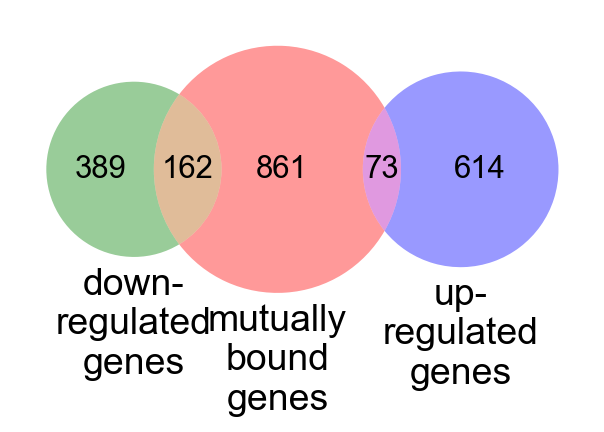

In [56]:
dp_cutnrun = list(set(genes_cutnrun_union["Ascl1_MyoD1"].tolist()).\
    intersection(set(genes_cutnrun_union["mAscl1_MyoD1"].tolist())))
set1 = set(dp_cutnrun)
set2 = set(cond_down_genes['mutantAscl1,Myod1']['Ascl1,Myod1'])
set3 = set(cond_up_genes['mutantAscl1,Myod1']['Ascl1,Myod1'])
venn3([set1, set2, set3], ('mutually\nbound\ngenes', 'down-\nregulated\ngenes', 'up-\nregulated\ngenes'))
plt.tight_layout()
plt.show()

CUT&Run: Bound by 'Ascl1,Myod1', 'Myod1'

GEX: 

    - down-regulated in 'Ascl1,Myod1' versus 'Myod1'
    - up-regulated in 'Ascl1,Myod1' versus 'Myod1'

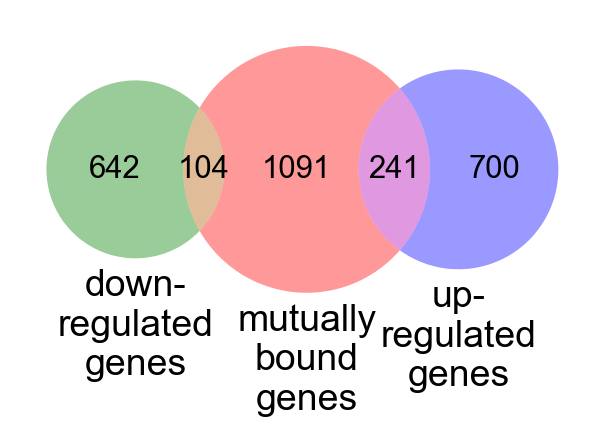

In [57]:
dp_cutnrun = list(set(genes_cutnrun_union["MyoD1"].tolist()).\
    intersection(set(genes_cutnrun_union["Ascl1_MyoD1"].tolist())))
set1 = set(dp_cutnrun)
set2 = set(cond_down_genes['Myod1']['Ascl1,Myod1'])
set3 = set(cond_up_genes['Myod1']['Ascl1,Myod1'])
venn3([set1, set2, set3], ('mutually\nbound\ngenes', 'down-\nregulated\ngenes', 'up-\nregulated\ngenes'))
plt.tight_layout()
plt.show()

CUT&Run: Bound by 'mutantAscl1,Myod1', 'Myod1'

GEX: 

    - down-regulated in 'mutantAscl1,Myod1' versus 'Myod1'
    - up-regulated in 'mutantAscl1,Myod1' versus 'Myod1'

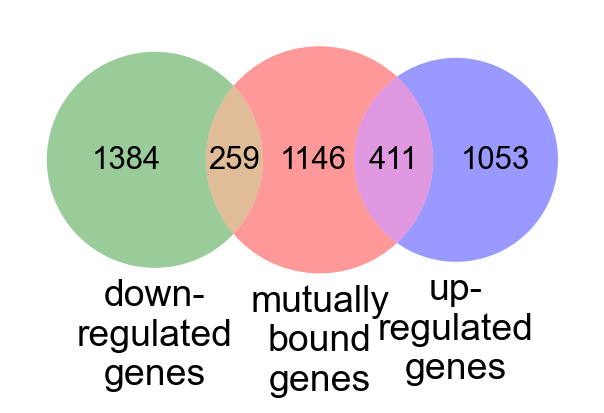

In [58]:
dp_cutnrun = list(set(genes_cutnrun_union["MyoD1"].tolist()).\
    intersection(set(genes_cutnrun_union["mAscl1_MyoD1"].tolist())))
set1 = set(dp_cutnrun)
set2 = set(cond_down_genes['Myod1']['mutantAscl1,Myod1'])
set3 = set(cond_up_genes['Myod1']['mutantAscl1,Myod1'])
venn3([set1, set2, set3], ('mutually\nbound\ngenes', 'down-\nregulated\ngenes', 'up-\nregulated\ngenes'))
plt.tight_layout()
plt.show()

CUT&Run: Bound by 'Ascl1,Myod1', 'Myod1'

GEX: 

    - up-regulated in 'Myod1' versus 'untransfected'
    - up-regulated in 'Ascl1,Myod1' versus 'untransfected'

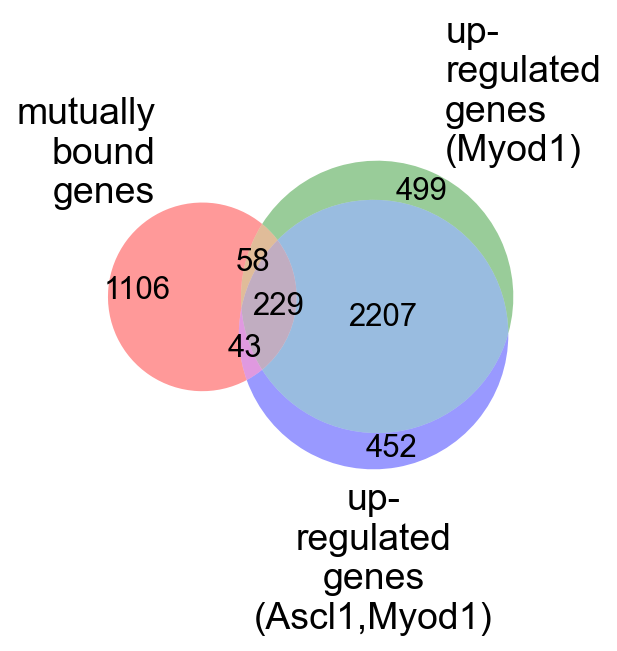

In [59]:
dp_cutnrun = list(set(genes_cutnrun_union["MyoD1"].tolist()).\
    intersection(set(genes_cutnrun_union["Ascl1_MyoD1"].tolist())))
set1 = set(dp_cutnrun)
set2 = set(cond_up_genes['untransfected']['Myod1'])
set3 = set(cond_up_genes['untransfected']['Ascl1,Myod1'])
venn3([set1, set2, set3], ('mutually\nbound\ngenes', 'up-\nregulated\ngenes\n(Myod1)', 'up-\nregulated\ngenes\n(Ascl1,Myod1)'))
plt.tight_layout()
plt.show()

CUT&Run: Bound by 'Ascl1,Myod1', 'Myod1'

GEX: 

    - down-regulated in 'Myod1' versus 'untransfected'
    - down-regulated in 'Ascl1,Myod1' versus 'untransfected'

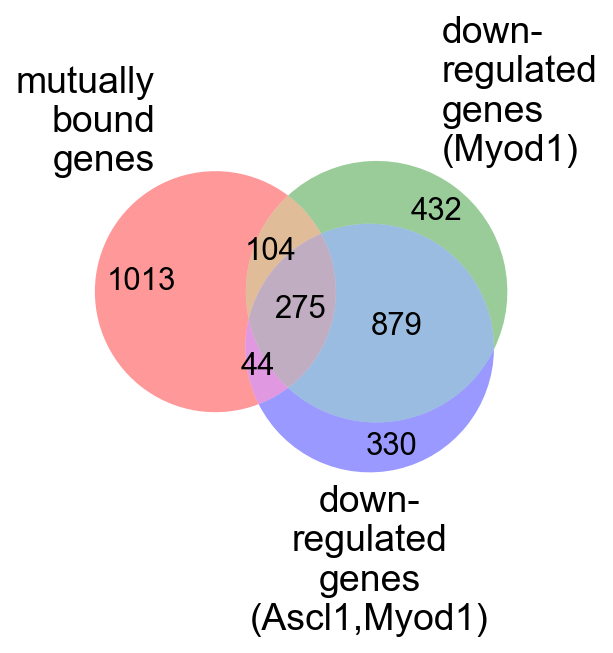

In [60]:
dp_cutnrun = list(set(genes_cutnrun_union["MyoD1"].tolist()).\
    intersection(set(genes_cutnrun_union["Ascl1_MyoD1"].tolist())))
set1 = set(dp_cutnrun)
set2 = set(cond_down_genes['untransfected']['Myod1'])
set3 = set(cond_down_genes['untransfected']['Ascl1,Myod1'])
venn3([set1, set2, set3], ('mutually\nbound\ngenes', 'down-\nregulated\ngenes\n(Myod1)', 'down-\nregulated\ngenes\n(Ascl1,Myod1)'))
plt.tight_layout()
plt.show()

CUT&Run: Bound by 'mutantAscl1,Myod1', 'Myod1'

GEX: 

    - up-regulated in 'Myod1' versus 'untransfected'
    - up-regulated in 'mutantAscl1,Myod1' versus 'untransfected'

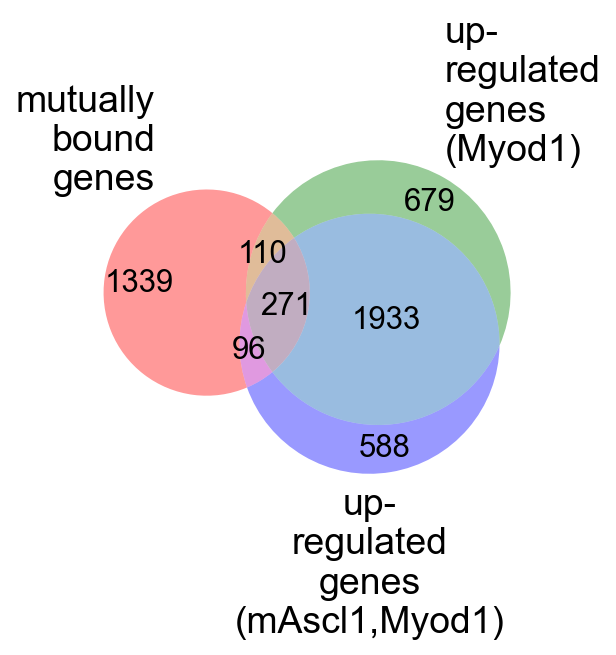

In [61]:
dp_cutnrun = list(set(genes_cutnrun_union["MyoD1"].tolist()).\
    intersection(set(genes_cutnrun_union["mAscl1_MyoD1"].tolist())))
set1 = set(dp_cutnrun)
set2 = set(cond_up_genes['untransfected']['Myod1'])
set3 = set(cond_up_genes['untransfected']['mutantAscl1,Myod1'])
venn3([set1, set2, set3], ('mutually\nbound\ngenes', 'up-\nregulated\ngenes\n(Myod1)', 'up-\nregulated\ngenes\n(mAscl1,Myod1)'))
plt.tight_layout()
plt.show()